In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from statsmodels.tsa.stattools import adfuller
import scipy.stats as stats
import nltk

from sklearn.cluster import KMeans

from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score, mean_squared_error

from tqdm import tqdm

from tsfresh import extract_features,select_features
from tsfresh.utilities.dataframe_functions import make_forecasting_frame, impute

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from sklearn.linear_model import ElasticNet,LinearRegression
from sklearn.ensemble import  AdaBoostRegressor

from sklearn.svm import LinearSVR


# Data Import

In [2]:
## Change me to /Users/joyvan if running on a virtual machine. 

home_directory = '/Users/milestaylor/Desktop'

In [3]:
## Empty dictionary initialized. Allows for efficent iteration by part.
## All dataframes will be merged to form one eventually, so individual names don't matter past Exploratory Data/Integrity Analysis and munging stages.
dynamic_dataframes = {}
## Empty list initalized for dynamic key: value look-ups without referencing documentation.
only_frame_names = []
## glob allows for pattern matching. Iterating through the file path to find all .csv files and load them into a dictionary of dataframes.
for file in glob.glob(f'{home_directory}/Lego/*.csv'):
    file_name = file.split('/')[-1]
    dataframe_name = file_name.split('.')[0]    
    only_frame_names.append(dataframe_name)
    with open(file) as b:
        dataframe_values = pd.read_csv(b)
        dynamic_dataframes.update({dataframe_name : dataframe_values})

## Part 1 - Data Merge

Note: inventory dataset analysis (see part 2A) yields only current inventory state. Outer joins used to get obsolete sets, colors,
themes for cluster analysis in Part 2B

In [4]:
## Included so we can see which dataframes are being referenced. Converted to a list and sorted so this works across systems.
framed_assembled = list(only_frame_names)
framed_assembled.sort()
framed_assembled

['colors',
 'inventories',
 'inventory_parts',
 'inventory_sets',
 'part_categories',
 'part_relationships',
 'parts',
 'sets',
 'themes']

In [5]:
## merging dataframes in the dictionary by reference. Reference names found above but it's part categories and parts.
partcat_part = pd.merge(dynamic_dataframes[framed_assembled[4]],dynamic_dataframes[framed_assembled[-3]], how = 'inner', left_on = 'id', right_on = 'part_cat_id')
partcat_part.columns = ["id", 'partcategory_names', 'part_num', "partcategory_description", 'partcat_id']
partcat_part.drop('id',axis = 1, inplace = True)

In [6]:
## merging partcategory_parts and inventory parts. Some parts have been discontinued and have no inventory values. Adding a flag
inventory_parts = pd.merge(partcat_part, dynamic_dataframes[framed_assembled[2]], on = 'part_num', how = 'left')
inventory_parts["isobsolete_partcategory"] = np.where(pd.isnull(inventory_parts.inventory_id), 1, 0 )

In [7]:
## merging inventory parts and colors. Left joining for an unused color check.
inventory_colors = pd.merge(dynamic_dataframes[framed_assembled[0]], inventory_parts , how = 'left', left_on = 'id', right_on = 'color_id')
unused_colors = inventory_colors[pd.isnull(inventory_colors.color_id) == True].copy()

## Unneeded so dropping and cleaning up column names.
inventory_colors['drop_flag'] = np.where(pd.isnull(inventory_colors.color_id) == True, 1, 0 )
inventory_colors = inventory_colors[inventory_colors.loc[:,'drop_flag'] == 0].copy()
inventory_colors.drop(['id','drop_flag'],axis = 1, inplace = True )
inventory_colors.columns = ['color_name','rgb','is_trans','partcategory_names','part_num','partcategory_description','partcat_id','inventory_id','color_id','quantity_part',
                             'is_spare','isobsolete_partcategory']

In [8]:
## Join this unto itself because it has the parent and the child themes. First make a deep copy.
cloned_themes = dynamic_dataframes[framed_assembled[-1]].copy()
## Right join bc sets.csv keys off the theme_id and some themes don't have children.
themes_parented = pd.merge(dynamic_dataframes[framed_assembled[-1]], cloned_themes , left_on = 'id', how = 'right', right_on = 'parent_id')
## clarity of columns.
themes_parented.columns = ['parent_themeid', 'parent_themename', 'is_parent', 'child_themeid', 'child_themename', 'duped_id']
## Some themes have children. Exposing them here and cleaning up column names again.
themes_parented.is_parent = np.where(np.isnan(themes_parented.is_parent) == True, 1, 2 )
themes_parented.drop('duped_id', axis = 1, inplace = True)
themes_parented.columns = ['parent_themeid', 'parent_themename', 'parent_level', 'child_themeid', 'child_themename']
## Completing the record because the right join also caused nulls. Cleaning that up here.
## Created level '0' for parent level as a way to query the no children themes.
themes_parented['parent_themename'] = np.where(np.isnan(themes_parented.parent_themeid) == True, themes_parented.child_themename, themes_parented.parent_themename)
themes_parented['parent_themeid'] = np.where(np.isnan(themes_parented.parent_themeid) == True, themes_parented.child_themeid, themes_parented.parent_themeid)
themes_parented['parent_level'] = np.where(themes_parented.parent_themeid == themes_parented.child_themeid, 0, themes_parented.parent_level )

In [9]:
## Sometimes the themes aren't part of a set.
set_themes = pd.merge(themes_parented, dynamic_dataframes[framed_assembled[-2]], left_on = 'child_themeid', right_on = 'theme_id', how = 'left')
set_themes.columns =  ['parent_themeid','parent_themename','parent_level','child_themeid','child_themename','set_num','set_name','year','sets_themeid','num_parts' ]

In [10]:
## joining with inventory sets
set_quantities = pd.merge(set_themes,dynamic_dataframes[framed_assembled[3]], how = 'left', on = 'set_num')

In [11]:
## joining with inventory 
inventory_partsets = pd.merge(set_quantities, dynamic_dataframes[framed_assembled[1]], on = 'set_num', how = 'left')
inventory_partsets.columns = ['parent_themeid','parent_themename','parent_level','child_themeid','child_themename','set_num','set_name','year','sets_themeid','set_numparts',
                             'sets_inventoryid','quantity_sets','partset_inventoryid','version' ]

In [12]:
## final join with inventory parts and colors. Right join to keep non-stocked themes
sandbox = pd.merge(inventory_colors,inventory_partsets, how = 'right', left_on = 'inventory_id', right_on ='partset_inventoryid' )

In [13]:
sandbox.head()

,color_name,rgb,is_trans,partcategory_names,part_num,partcategory_description,partcat_id,inventory_id,color_id,quantity_part,...,child_themename,set_num,set_name,year,sets_themeid,set_numparts,sets_inventoryid,quantity_sets,partset_inventoryid,version
0,[Unknown],0033B2,f,"Duplo, Quatro and Primo",3437,Duplo Brick 2 x 2,4.0,27705.0,-1.0,4.0,...,Basic Set,4296-1,Green Strata,2004.0,505.0,260.0,NaN,NaN,27705.0,1.0
1,Black,05131D,f,"Duplo, Quatro and Primo",31110,Duplo Brick 2 x 2 x 2,4.0,27705.0,0.0,1.0,...,Basic Set,4296-1,Green Strata,2004.0,505.0,260.0,NaN,NaN,27705.0,1.0
2,Black,05131D,f,"Duplo, Quatro and Primo",6394,Duplo Brick 2 x 4 x 2 with 2 x 2 Square Arch,4.0,27705.0,0.0,1.0,...,Basic Set,4296-1,Green Strata,2004.0,505.0,260.0,NaN,NaN,27705.0,1.0
3,Blue,0055BF,f,"Duplo, Quatro and Primo",2301,Duplo Brick 2 x 3 x 2 with Curve,4.0,27705.0,1.0,2.0,...,Basic Set,4296-1,Green Strata,2004.0,505.0,260.0,NaN,NaN,27705.0,1.0
4,Blue,0055BF,f,"Duplo, Quatro and Primo",2302,Duplo Brick 2 x 3 with Curved Top,4.0,27705.0,1.0,4.0,...,Basic Set,4296-1,Green Strata,2004.0,505.0,260.0,NaN,NaN,27705.0,1.0


In [14]:
len(sandbox)

769101

In [16]:
## Changing year to proper dtype. Other columns repr'd as float, but this doesn't affect data quality. 
## Also re-ordering the columns and seperating the df into id and dimensions/facts for my sanity.

sandbox.year = sandbox.year.apply(lambda x: x if pd.isnull(x) == True else str(x)[:-2] + '-01-01')
sandbox.year = sandbox.year.apply(lambda x: pd.to_datetime(x))

In [17]:
sandbox = sandbox[['partcat_id','inventory_id', 'color_id', 'parent_themeid','child_themeid','sets_themeid', 'sets_inventoryid',
                  'partset_inventoryid', 'parent_level', 'year', 'parent_themename', 'child_themename','partcategory_names','partcategory_description',
                    'isobsolete_partcategory', 'set_name', 'version','color_name', 'set_num',  'rgb', 'is_trans','is_spare', 'part_num', 'quantity_part', 'quantity_sets',    
                     'set_numparts']].copy()

## Part 2 

## Part 2 A - Exploratory Data Analysis

Note: The following sub-section (2A) was done before Part 1 because I needed to understand the dataframes as seperate components before I could merge. That is why throughout this section I don't use the final dataframe, but its parts.

### Descriptive Statistics

#### Output

In [18]:
## Integrity checks below
## The count of the each of the primary keys involved in the dataframes show the null values possible along with relationships
## Descriptive statistics and the first 10 values for a sneek peak before data gets joined 

frame_position = 0 
for i in range(0,len(only_frame_names)):
    print(f'DATAFRAME NAME : {only_frame_names[frame_position].upper()}')
    dynamic_dataframes[only_frame_names[frame_position]].head(10)
    print(f'----------------------NULL VALUE CHECK OF {only_frame_names[frame_position].upper()}-----------------------')
    dynamic_dataframes[only_frame_names[frame_position]].info()
    print(f'----------------------DESCRIPTIVE STATISTICS OF {only_frame_names[frame_position].upper()}------------------')
    dynamic_dataframes[only_frame_names[frame_position]].describe()
    print(f'-------------------------END OF {only_frame_names[frame_position].upper()}----------------------------------')
    frame_position+= 1

DATAFRAME NAME : PART_CATEGORIES


,id,name
0,1,Baseplates
1,2,Bricks Printed
2,3,Bricks Sloped
3,4,"Duplo, Quatro and Primo"
4,5,Bricks Special
5,6,Bricks Wedged
6,7,Containers
7,8,Technic Bricks
8,9,Plates Special
9,10,Tiles Printed


----------------------NULL VALUE CHECK OF PART_CATEGORIES-----------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 2 columns):
id      66 non-null int64
name    66 non-null object
dtypes: int64(1), object(1)
memory usage: 1.1+ KB
----------------------DESCRIPTIVE STATISTICS OF PART_CATEGORIES------------------


,id
count,66.000000
mean,33.500000
std,19.196354
min,1.000000
25%,17.250000
50%,33.500000
75%,49.750000
max,66.000000


-------------------------END OF PART_CATEGORIES----------------------------------
DATAFRAME NAME : INVENTORIES


,id,version,set_num
0,1,1,7922-1
1,3,1,3931-1
2,4,1,6942-1
3,15,1,5158-1
4,16,1,903-1
5,17,1,850950-1
6,19,1,4444-1
7,21,1,3474-1
8,22,1,30277-1
9,25,1,71012-11


----------------------NULL VALUE CHECK OF INVENTORIES-----------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14711 entries, 0 to 14710
Data columns (total 3 columns):
id         14711 non-null int64
version    14711 non-null int64
set_num    14711 non-null object
dtypes: int64(2), object(1)
memory usage: 344.9+ KB
----------------------DESCRIPTIVE STATISTICS OF INVENTORIES------------------


,id,version
count,14711.000000,14711.000000
mean,12295.582149,1.016518
std,8704.215593,0.146332
min,1.000000,1.000000
25%,5362.000000,1.000000
50%,10732.000000,1.000000
75%,16084.500000,1.000000
max,32930.000000,5.000000


-------------------------END OF INVENTORIES----------------------------------
DATAFRAME NAME : PARTS


,part_num,name,part_cat_id
0,0687b1,Set 0687 Activity Booklet 1,17
1,0901,Baseplate 16 x 30 with Set 080 Yellow House Print,1
2,0902,Baseplate 16 x 24 with Set 080 Small White Hou...,1
3,0903,Baseplate 16 x 24 with Set 080 Red House Print,1
4,0904,Baseplate 16 x 24 with Set 080 Large White Hou...,1
5,1,Homemaker Bookcase 2 x 4 x 4,7
6,10,Baseplate 24 x 32,1
7,10000,Duplo Animal Brick 2 x 2 Elephant Head,4
8,10016414,Sticker Sheet #1 for 41055-1,58
9,10019stk01,Sticker for Set 10019 - (43274/4170393),58


----------------------NULL VALUE CHECK OF PARTS-----------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31970 entries, 0 to 31969
Data columns (total 3 columns):
part_num       31970 non-null object
name           31970 non-null object
part_cat_id    31970 non-null int64
dtypes: int64(1), object(2)
memory usage: 749.4+ KB
----------------------DESCRIPTIVE STATISTICS OF PARTS------------------


,part_cat_id
count,31970.000000
mean,36.823491
std,22.396352
min,1.000000
25%,16.000000
50%,41.000000
75%,59.000000
max,66.000000


-------------------------END OF PARTS----------------------------------
DATAFRAME NAME : PART_RELATIONSHIPS


,rel_type,child_part_num,parent_part_num
0,A,50990b,50990a
1,P,3298pb010,3298
2,P,19729pr0013a,19729
3,P,3070bpb043,3070b
4,P,6180pb017l,6180
5,P,76371pr0109,76371
6,P,3626cpr1951,3626c
7,P,3626cpr9970,3626c
8,P,76371pr0112,76371
9,P,3069bpr0235,3069b


----------------------NULL VALUE CHECK OF PART_RELATIONSHIPS-----------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17720 entries, 0 to 17719
Data columns (total 3 columns):
rel_type           17720 non-null object
child_part_num     17720 non-null object
parent_part_num    17720 non-null object
dtypes: object(3)
memory usage: 415.4+ KB
----------------------DESCRIPTIVE STATISTICS OF PART_RELATIONSHIPS------------------


,rel_type,child_part_num,parent_part_num
count,17720,17720,17720
unique,4,17508,2085
top,P,bslot03c,973c00
freq,16508,5,3308


-------------------------END OF PART_RELATIONSHIPS----------------------------------
DATAFRAME NAME : INVENTORY_SETS


,inventory_id,set_num,quantity
0,35,75911-1,1
1,35,75912-1,1
2,39,75048-1,1
3,39,75053-1,1
4,50,4515-1,1
5,50,4520-1,2
6,50,4531-1,1
7,71,7690-1,1
8,71,7691-1,1
9,71,7692-1,1


----------------------NULL VALUE CHECK OF INVENTORY_SETS-----------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3189 entries, 0 to 3188
Data columns (total 3 columns):
inventory_id    3189 non-null int64
set_num         3189 non-null object
quantity        3189 non-null int64
dtypes: int64(2), object(1)
memory usage: 74.8+ KB
----------------------DESCRIPTIVE STATISTICS OF INVENTORY_SETS------------------


,inventory_id,quantity
count,3189.000000,3189.000000
mean,10436.399812,1.379116
std,7610.931053,4.556375
min,35.000000,1.000000
25%,4643.000000,1.000000
50%,9149.000000,1.000000
75%,14390.000000,1.000000
max,32765.000000,60.000000


-------------------------END OF INVENTORY_SETS----------------------------------
DATAFRAME NAME : INVENTORY_PARTS


,inventory_id,part_num,color_id,quantity,is_spare
0,1,48379c01,72,1,f
1,1,48395,7,1,f
2,1,mcsport6,25,1,f
3,1,paddle,0,1,f
4,3,11816pr0005,78,1,f
5,3,2343,47,1,f
6,3,3003,29,1,f
7,3,30176,2,1,f
8,3,3020,15,1,f
9,3,3022,15,2,f


----------------------NULL VALUE CHECK OF INVENTORY_PARTS-----------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 733164 entries, 0 to 733163
Data columns (total 5 columns):
inventory_id    733164 non-null int64
part_num        733164 non-null object
color_id        733164 non-null int64
quantity        733164 non-null int64
is_spare        733164 non-null object
dtypes: int64(3), object(2)
memory usage: 28.0+ MB
----------------------DESCRIPTIVE STATISTICS OF INVENTORY_PARTS------------------


,inventory_id,color_id,quantity
count,733164.000000,733164.000000,733164.000000
mean,11873.843155,82.927603,3.238807
std,8019.551476,629.947530,8.063923
min,1.000000,-1.000000,1.000000
25%,5434.000000,2.000000,1.000000
50%,10813.000000,15.000000,2.000000
75%,16015.000000,71.000000,3.000000
max,32930.000000,9999.000000,1440.000000


-------------------------END OF INVENTORY_PARTS----------------------------------
DATAFRAME NAME : COLORS


,id,name,rgb,is_trans
0,-1,[Unknown],0033B2,f
1,0,Black,05131D,f
2,1,Blue,0055BF,f
3,2,Green,237841,f
4,3,Dark Turquoise,008F9B,f
5,4,Red,C91A09,f
6,5,Dark Pink,C870A0,f
7,6,Brown,583927,f
8,7,Light Gray,9BA19D,f
9,8,Dark Gray,6D6E5C,f


----------------------NULL VALUE CHECK OF COLORS-----------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 4 columns):
id          178 non-null int64
name        178 non-null object
rgb         178 non-null object
is_trans    178 non-null object
dtypes: int64(1), object(3)
memory usage: 5.6+ KB
----------------------DESCRIPTIVE STATISTICS OF COLORS------------------


,id
count,178.000000
mean,440.488764
std,833.769903
min,-1.000000
25%,54.750000
50%,149.000000
75%,1006.750000
max,9999.000000


-------------------------END OF COLORS----------------------------------
DATAFRAME NAME : SETS


,set_num,name,year,theme_id,num_parts
0,00-1,Weetabix Castle,1970,414,471
1,001-1,Gears,1965,1,43
2,0011-2,Town Mini-Figures,1978,84,12
3,0011-3,Castle 2 for 1 Bonus Offer,1987,199,2
4,0012-1,Space Mini-Figures,1979,143,12
5,0013-1,Space Mini-Figures,1979,143,12
6,0014-1,Space Mini-Figures,1979,143,12
7,0015-1,Space Mini-Figures,1979,143,18
8,0016-1,Castle Mini Figures,1978,186,15
9,00-2,Weetabix Promotional House 1,1976,413,147


----------------------NULL VALUE CHECK OF SETS-----------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14498 entries, 0 to 14497
Data columns (total 5 columns):
set_num      14498 non-null object
name         14498 non-null object
year         14498 non-null int64
theme_id     14498 non-null int64
num_parts    14498 non-null int64
dtypes: int64(3), object(2)
memory usage: 566.4+ KB
----------------------DESCRIPTIVE STATISTICS OF SETS------------------


,year,theme_id,num_parts
count,14498.000000,14498.000000,14498.000000
mean,2003.260174,363.876190,156.429783
std,13.702247,193.039879,340.525635
min,1949.000000,1.000000,-1.000000
25%,1998.000000,201.000000,9.000000
50%,2007.000000,409.000000,42.000000
75%,2014.000000,505.000000,155.000000
max,2019.000000,675.000000,7541.000000


-------------------------END OF SETS----------------------------------
DATAFRAME NAME : THEMES


,id,name,parent_id
0,1,Technic,NaN
1,2,Arctic Technic,1.0
2,3,Competition,1.0
3,4,Expert Builder,1.0
4,5,Model,1.0
5,6,Airport,5.0
6,7,Construction,5.0
7,8,Farm,5.0
8,9,Fire,5.0
9,10,Harbor,5.0


----------------------NULL VALUE CHECK OF THEMES-----------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669 entries, 0 to 668
Data columns (total 3 columns):
id           669 non-null int64
name         669 non-null object
parent_id    549 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 15.8+ KB
----------------------DESCRIPTIVE STATISTICS OF THEMES------------------


,id,parent_id
count,669.000000,549.000000
mean,337.581465,293.174863
std,195.928821,184.631312
min,1.000000,1.000000
25%,168.000000,126.000000
50%,335.000000,290.000000
75%,508.000000,482.000000
max,676.000000,632.000000


-------------------------END OF THEMES----------------------------------


#### Analyst Notes - EDA

**looking at the individual dataframes before merging into one there are few insights we gain**: 

1. There seems to be no null values within the dataset. This means we can do inner joins without dropping rows. Care needs to be still taken when doing so because the -1 surrogate keys mean outer joins might be required (see: colors dataframe).
2. Inventory only accounts for current inventory values. Must outer join now to get the full data over time if I would like to cluster or create a classification model not based on current values. 
3. Necessary feature transformation needs to be conducted before any predictive analysis is conducted. In particular we should one-hot encode the transparency value of the colors, and the spare values of the inventory sets. Esepcially so, if a logit model is used later on to predict either outcome.
4. Datatypes are not being uniformly enforced ( the ints are floats and the year column is an int) this needs to be corrected upon before analysis. 

### Graphical Exploratory Data Analysis

#### Output

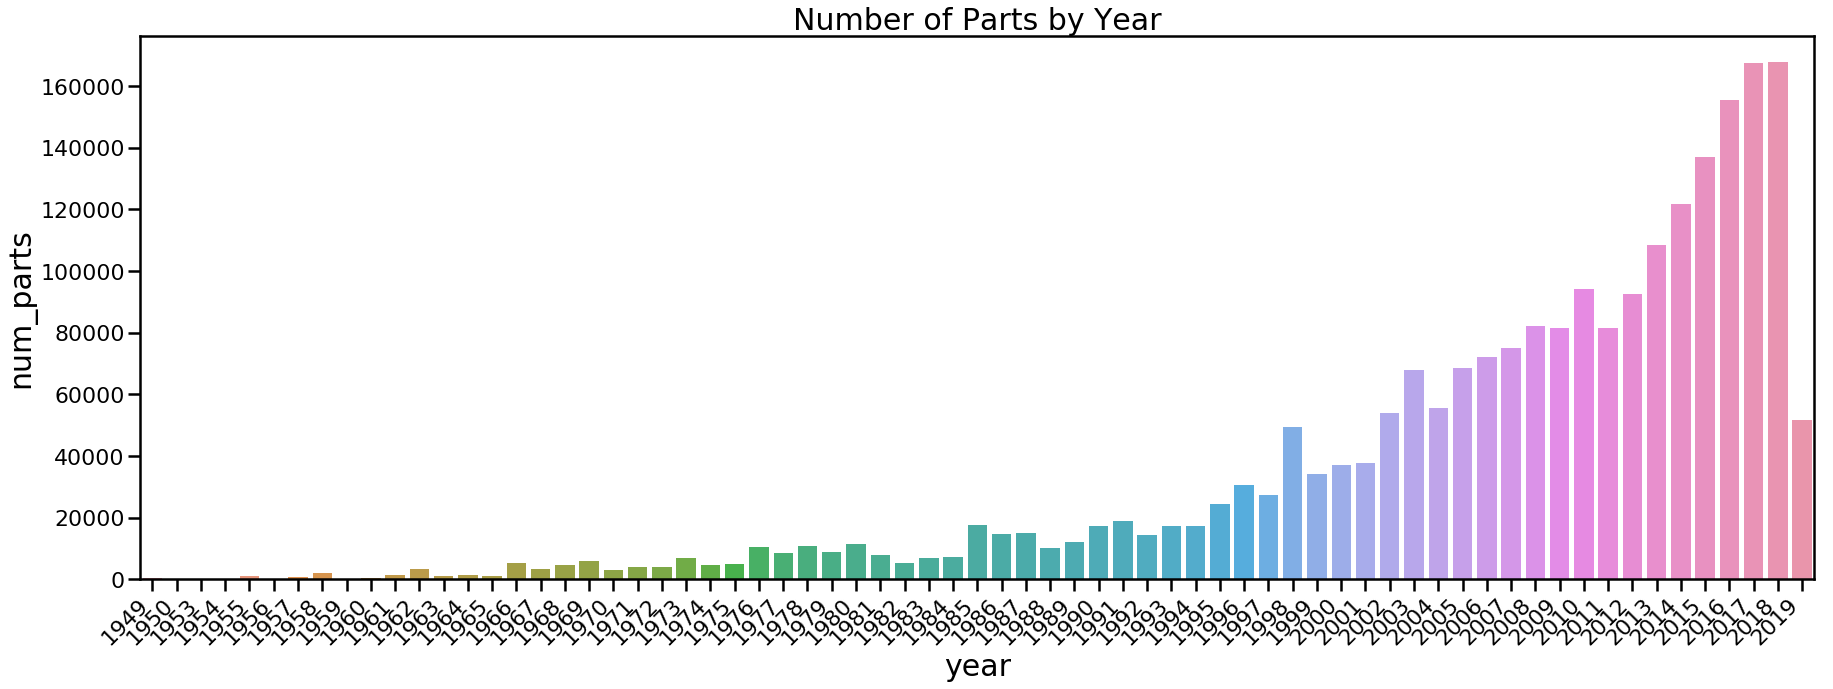

In [19]:
sns.set_context("poster", rc={"font.size":40,"axes.titlesize":30,"axes.labelsize":30})   
_ = plt.figure(figsize=(30, 10))
ax = sns.barplot(x = dynamic_dataframes[framed_assembled[-2]].groupby('year').sum().index, y = dynamic_dataframes[framed_assembled[-2]].groupby('year').sum()['num_parts'], 
                 data = dynamic_dataframes[framed_assembled[-2]].groupby('year').sum(), orientation = 'vertical')
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
_ = plt.title("Number of Parts by Year")
plt.show()

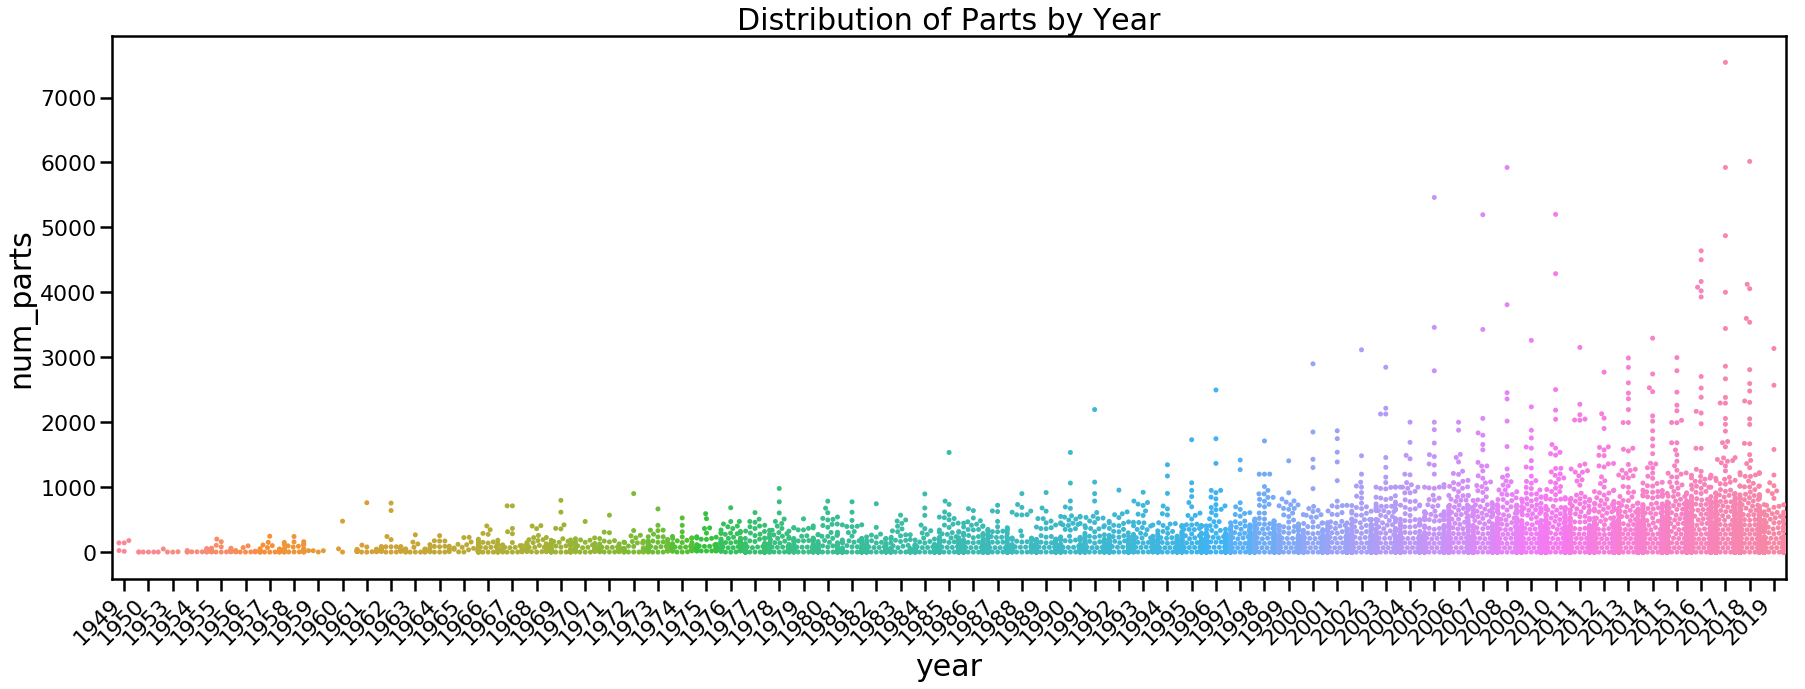

In [20]:
sns.set_context("poster", rc={"font.size":40,"axes.titlesize":30,"axes.labelsize":30})   
_ = plt.figure(figsize=(30, 10))
ax = sns.swarmplot(x = dynamic_dataframes[framed_assembled[-2]]['year'], y = dynamic_dataframes[framed_assembled[-2]]['num_parts'], 
                 data = dynamic_dataframes[framed_assembled[-2]])
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
_ = plt.title("Distribution of Parts by Year")
plt.show()

In [21]:
def test_stationarity(timeseries):    
    '''
Purpose: Test if a series has a unit-root present. 

Reason: There is a deterministic intercept present in every linear regression model (it can be written as the sum of squares) 
with a stochastic element, there are times when integration happens along the series. In other words, when one sums the probabilities  
of future events they are not constant because the function is acting upon itself at (t + 1) time period, where t denotes the current time period.
This may cause the probabilities to add up to be more than theoretically possible. The augmented dickey-fuller test adds another variable 
to the regression model (a(t-1)) to check if the most recent past variable can predict t steps into the future.
    ''' 

   ## Determing rolling statistics.
   ## Using 6 here to account for generational changes of LEGO customers to see better approx. 
    rolmean = timeseries.rolling(window = 6).mean()
    rolstd = timeseries.rolling(window = 6).std()

    ## Plot rolling statistics:
    sns.set_context("poster", rc={"font.size":40,"axes.titlesize":20,"axes.labelsize":30})   
    figure = plt.figure(figsize=(12, 8))
    original_plot = sns.lineplot(data = timeseries, color = 'yellow',label = 'Original_Line')
    mean = sns.lineplot(data = rolmean, color = 'red', label='Rolling Mean')
    standard_deviation = sns.lineplot(data = rolstd, color = 'green', label = 'Rolling Std')
    _ = plt.legend(loc ='best')
    _ = plt.title(f'Rolling Mean & Standard Deviation of {timeseries.name}')
    plt.show()
    

    ## Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    ## The ctt argument denotes a quadratic linear trend associated with the variable. 
    ## Use AIC here because the adfuller test conducts regression
    ## the aim of this test is to find a consitent approx of unit-root based on one model, not many.
    adftest = adfuller(timeseries, regression = 'ctt', autolag ='AIC')
    adfoutput = pd.Series(adftest[:5], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used', 'Rejection Values'])
    for key,value in timeseries.items():
        adfoutput[f'Critical Value {key}'] = value
    print(adfoutput[:5])

In [22]:
numparts_as_series = pd.Series(data = dynamic_dataframes[framed_assembled[-2]].groupby('year').sum()['num_parts'], 
                               index = dynamic_dataframes[framed_assembled[-2]].groupby('year').sum()['num_parts'].index)

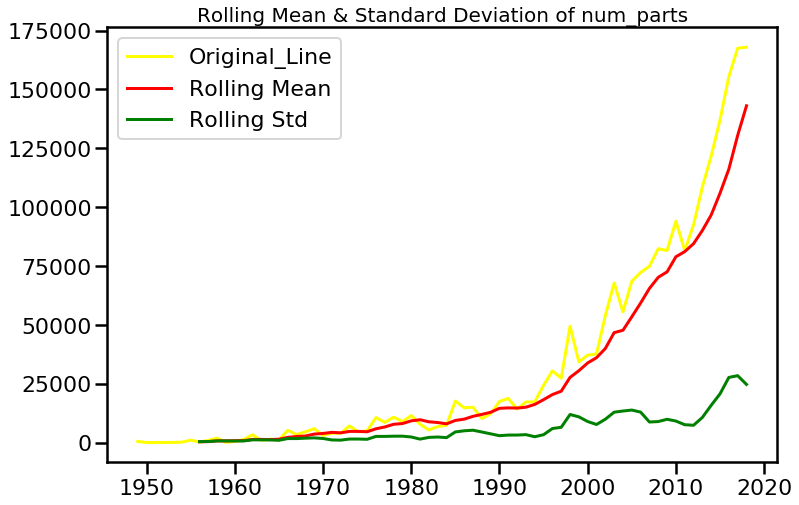

Results of Dickey-Fuller Test:
Test Statistic                                                          0.878443
p-value                                                                        1
#Lags Used                                                                    10
Number of Observations Used                                                   57
Rejection Values               {'1%': -4.587260155027458, '5%': -3.9404817383...
dtype: object


In [23]:
## 2019 only has a partial values. Taking this out of the set

numparts_2018 = numparts_as_series[:-1]

test_stationarity(numparts_2018)

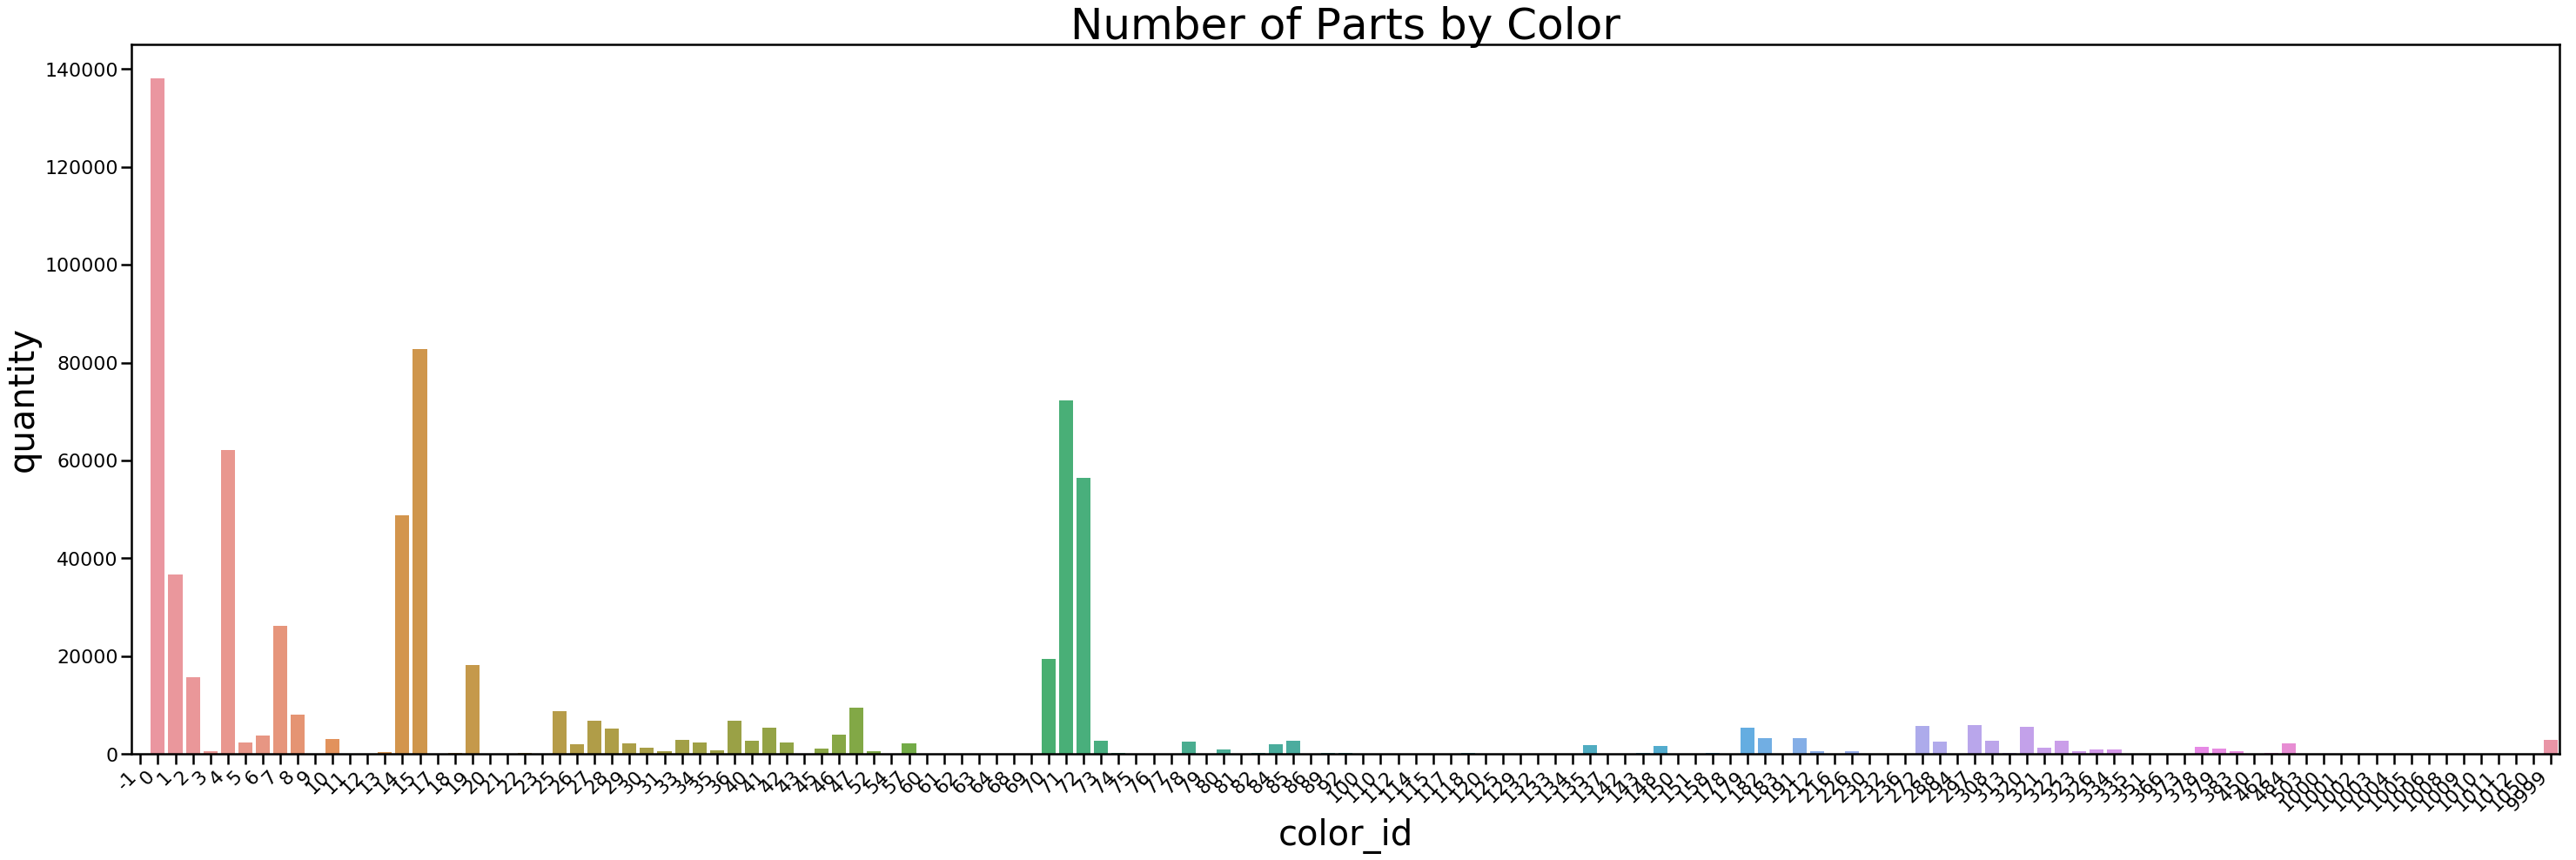

In [24]:
sns.set_context("poster", rc={"font.size":40,"axes.titlesize":50,"axes.labelsize":40})   
_ = plt.figure(figsize=(50, 15))
ax = sns.barplot(x = dynamic_dataframes[framed_assembled[2]].groupby('color_id').count().index, 
                 y = dynamic_dataframes[framed_assembled[2]].groupby('color_id').count()['quantity'], 
                 data = dynamic_dataframes[framed_assembled[2]].groupby('color_id').count(), orientation = 'vertical')
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = "right")
_ = plt.title("Number of Parts by Color")
plt.show()

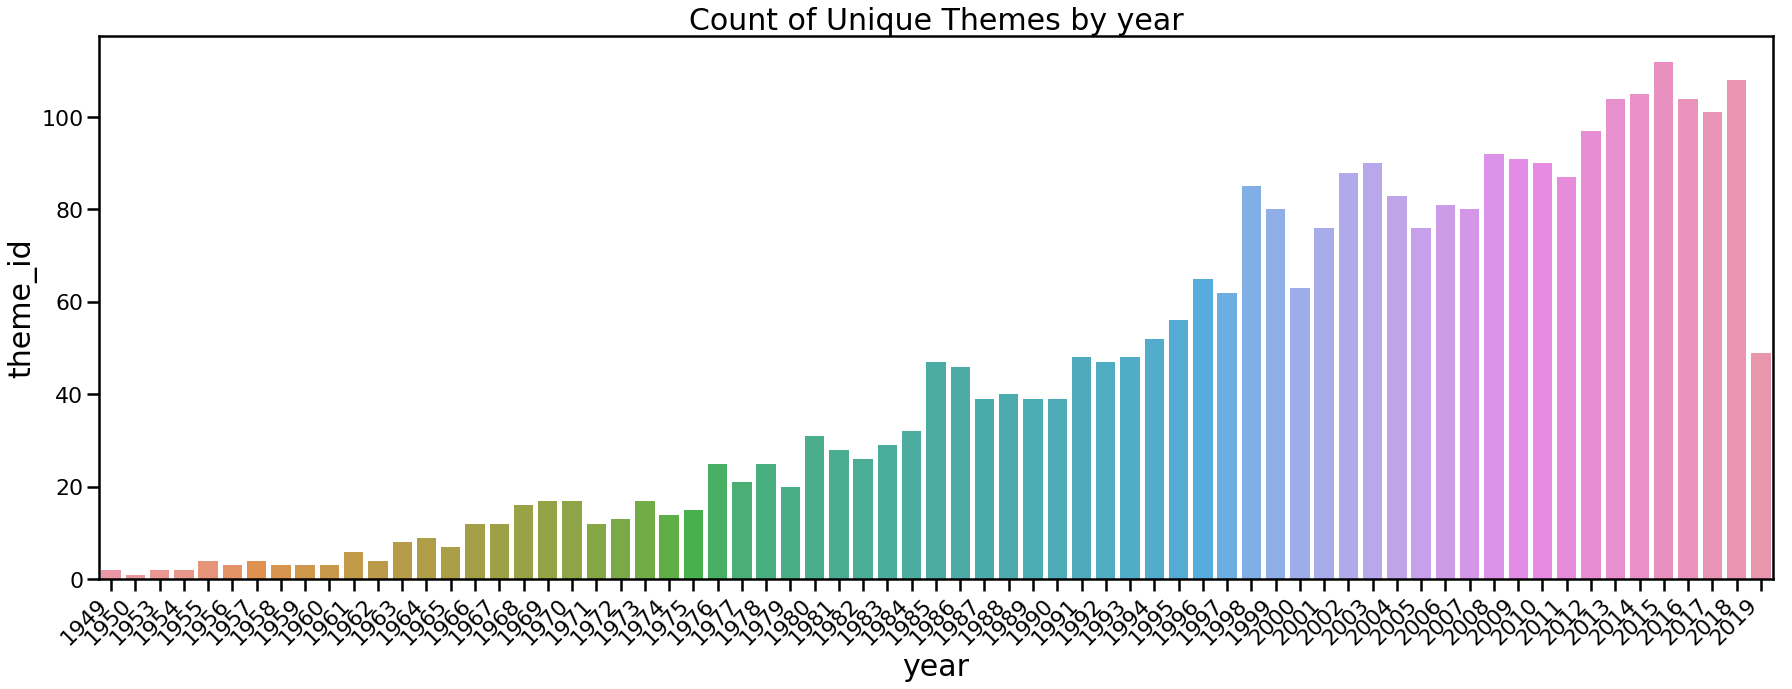

In [25]:
sns.set_context("poster", rc={"font.size":40,"axes.titlesize":30,"axes.labelsize":30})   
_ = plt.figure(figsize=(30, 10))
ax = sns.barplot(x = dynamic_dataframes[framed_assembled[-2]].groupby('year').nunique()['theme_id'].index, 
                 y = dynamic_dataframes[framed_assembled[-2]].groupby('year').nunique()['theme_id'], 
                 data = dynamic_dataframes[framed_assembled[-2]].groupby('year').nunique(), orientation = 'vertical')
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = "right")
_ = plt.title("Count of Unique Themes by year")
plt.show()

In [26]:
themes_as_series = pd.Series(data = dynamic_dataframes[framed_assembled[-2]].groupby('year').nunique()['theme_id'], 
                             index = dynamic_dataframes[framed_assembled[-2]].groupby('year').nunique()['theme_id'].index)

In [27]:
## Again need to remove 2019 to stop skewness for the 'moments' in the time-series
themes_2018 = themes_as_series[:-1]

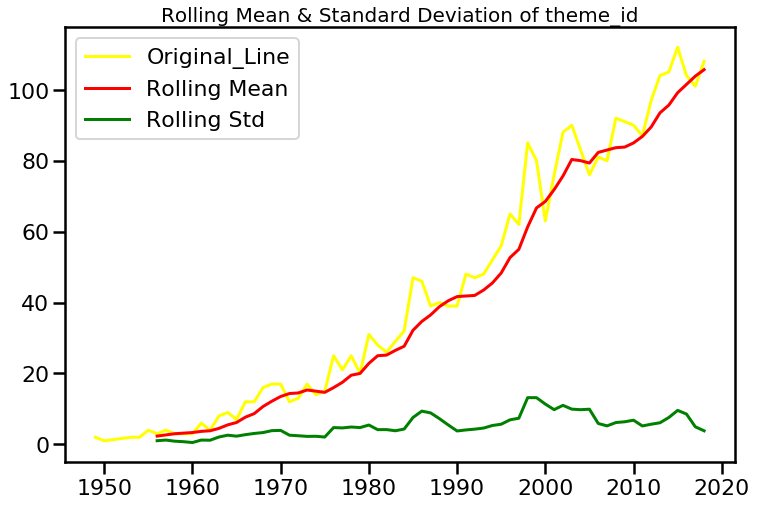

Results of Dickey-Fuller Test:
Test Statistic                                                           -4.7686
p-value                                                               0.00249255
#Lags Used                                                                     0
Number of Observations Used                                                   67
Rejection Values               {'1%': -4.5531781568544005, '5%': -3.923710412...
dtype: object


In [28]:
test_stationarity(themes_2018)

In [29]:
## For a short regression model
themed_parts = pd.concat([dynamic_dataframes[framed_assembled[-2]].groupby('year').nunique()['theme_id'],
                          dynamic_dataframes[framed_assembled[-2]].groupby('year').sum()['num_parts']], axis = 1)

In [30]:
themed_parts.columns = ['Count of Unique Themes', 'Summed Part Quantities']

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/tight_layout.py:199: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


<Figure size 2160x720 with 0 Axes>

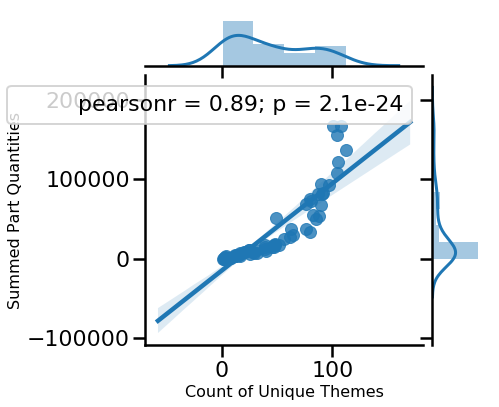

In [31]:
## Joint plot shows the distribution of the two variables selected along with a regression line
## Both are fairly normal approximations and the high variable assocation (taking unit-rootedness aside) means they probably 
## contain the same amount of information. Wouldn't be the best varaibles for regression selection unless time is specficially address

_ = sns.set_context("poster", rc = {"font.size" : 40,"axes.titlesize" : 30,"axes.labelsize" : 16})   
_ = plt.figure(figsize = (30, 10))
p = sns.jointplot(x = 'Count of Unique Themes', y = 'Summed Part Quantities', kind = 'reg', data = themed_parts)


_ = p.annotate(stats.pearsonr)

plt.show()

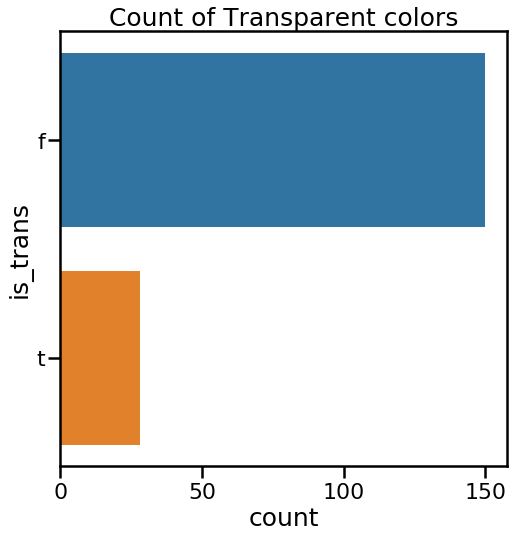

In [32]:
## Graph is hidden. Click on elipsis below to expand. Wanted to check the counts graphically

sns.set_context("poster", rc = {"font.size" : 25,"axes.titlesize" : 25,"axes.labelsize":25})   
_ = plt.figure(figsize = (8, 8))
sns.countplot(y = 'is_trans', data = dynamic_dataframes[framed_assembled[0]])
_ = plt.title("Count of Transparent colors")
plt.show()

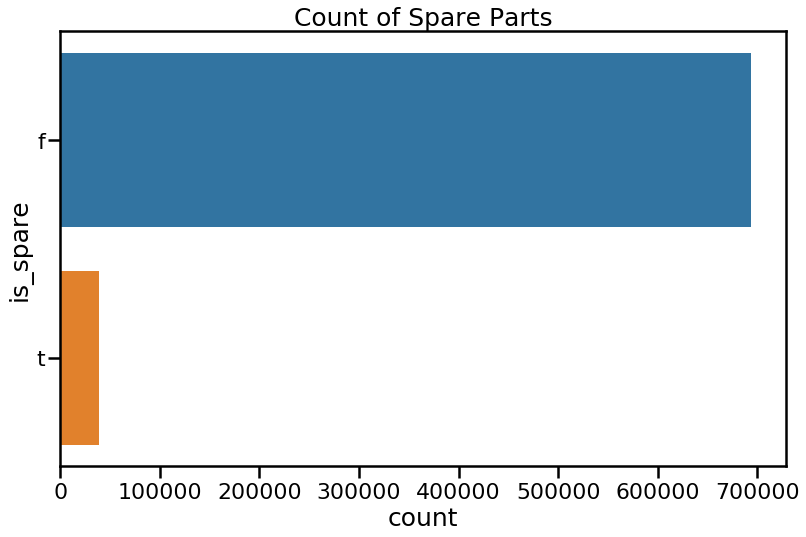

In [33]:
## see above please

sns.set_context("poster", rc = {"font.size" : 25,"axes.titlesize":25,"axes.labelsize":25})   
_ = plt.figure(figsize=(13, 8))
sns.countplot(y = 'is_spare', data = dynamic_dataframes[framed_assembled[2]])
_ = plt.title("Count of Spare Parts")
plt.show()

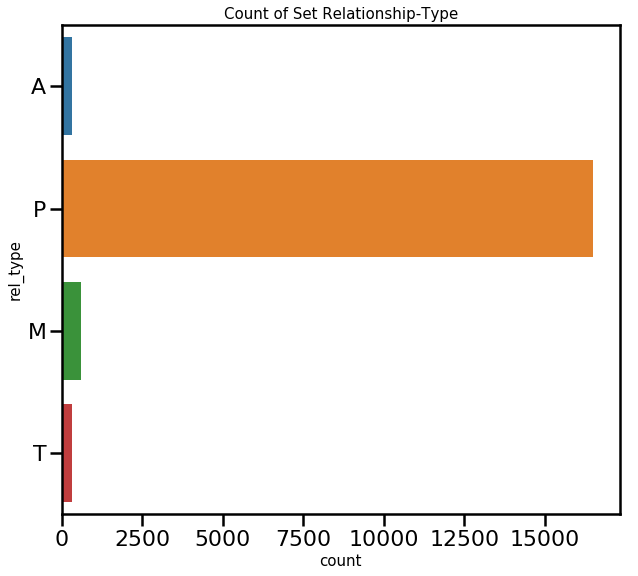

In [34]:
sns.set_context("poster", rc = {"font.size" : 15,"axes.titlesize" : 15,"axes.labelsize" : 15})   
_ = plt.figure(figsize = (10, 9))
sns.countplot(y = 'rel_type', data = dynamic_dataframes[framed_assembled[5]])
_ = plt.title("Count of Set Relationship-Type")
plt.show()

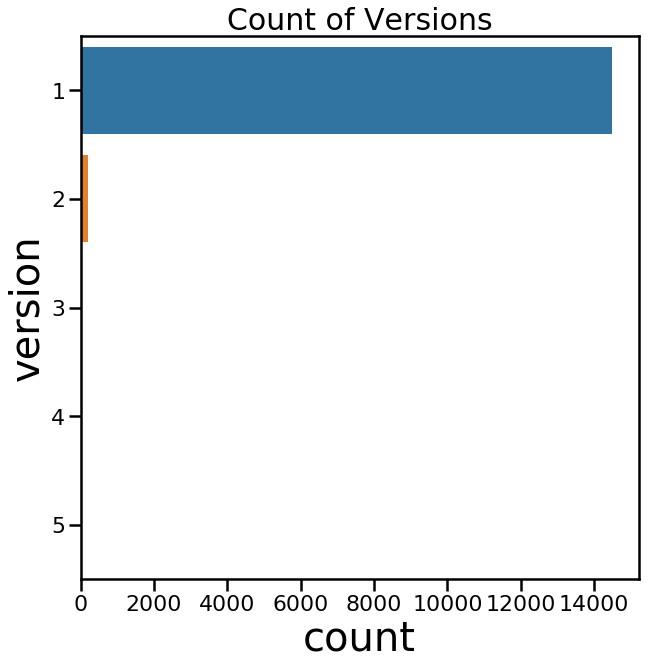

In [35]:
## Again see above 
sns.set_context("poster", rc = {"font.size" : 40,"axes.titlesize" : 30,"axes.labelsize" : 40})   
_ = plt.figure(figsize = (10, 10))
sns.countplot(y = 'version', data = dynamic_dataframes[framed_assembled[1]])
_ = plt.title("Count of Versions")
plt.show()

#### Analyst Notes - Graph EDA

1. It's interesting looking at the summed quantity totals by year in comparison to the distribution of those totals by year. If we were to do a predictive univariate model without corrective measures it would be near impossible to predict the number of pieces by year. In general, it seems as if the trend is increasing, but looking at the distribution of those pieces there are outlier values. This heavily swings MLE linear regression models. This would be something to investigate once I join the data together to get more context if this is possible for a regression task.
2. Even if there are a high amount of pieces in circulation, this doesn't seem to mean there is a high amount of pieces based on color. Maybe there has been a  proliferation of sets over the years rather than the amount of pieces per set getting more complex and distinct from one another. 
3. This insight seems to be confirmed by looking at the amount of themes that are released by year. Although, in general, there seems to be a positive correlation between the amount of sets released and the amount of pieces in circulation there are times such as in 2006-2008 where this trend diverges from the norm. There also seems to suggest something with the lego dataset itself that needs to be resolved. In particular a lego set was released in two different years which registers as a different theme each time but with the same name. (Maybe look at version number here). 
4. It's important before any predictive work done to decompose the reasons as to why 2019 as a whole seems to be so different than the rest of the dataset.
5. The dickey-fuller tests ran for unit-rootedness failed at the 10% level for the num parts. This supports the theory that a regression model shouldn't focus on the num parts directly without focusing on the time variant nature of the series. It is, however, possible to look at the number of themes over time and predict that using an ARIMA model order of (0,0,x) where x indicates the number of moving average windows you would like to introduce into the series.
6. This leads me to the second part of this workbook where I try to look at the number of part categories and sets over time. Since themes are num parts have such high association values it follows that the parts that make up these themes should be looked at and analyzed over time. 


## Part 2B - Part Category and Set Name Clustering

Note: Run the first three commands below if you are executing script on a new machine for the first time.
If you receive a ssl certification error, then you need to update 
the certifi bundle in symlink.
Do this by running /Applications/Python \  {INSERT VERSION #} / Install \ Certifcates.command in either the terminal (MacOSX/Linux) or Powershell (Windows). Please note if you are using windows your slashes are reversed.

In [36]:
#nltk.download('punkt')

In [37]:
#nltk.download('averaged_perceptron_tagger')

In [38]:
#nltk.download('wordnet')

In [39]:
def keywords_tracker(dataframe):
    
    '''
Purpose : Go through all lines in a dataframe column or series. Seperating out the words which compose the lines
into their morophological meaning. Then getting a count of the occurences for each of those words and finally
creating a keyword only set for easy access.

    '''   

    word_chop = nltk.wordnet.WordNetLemmatizer() ## Like a stemmer, but looks at the morphological influence of the word.
    root_words  = {}  ## collect the roots from the lines.
    filtered_root_association = {}  ## show association between root & keyword.
    keyword_count  = {}  ## count of each keyword. 
    want_word = lambda pos: pos[:2] in ['NN', 'NNS', 'RB'] ##  Looking for nouns plural (NNS), singular (NN), and adverbs (RB). 
                                                           ##  Things like ninjago are classified as an adverb.
    
    for word in dataframe:

        try:
            
            row = word.lower()
            tokend_row = nltk.word_tokenize(row)
            right_words = [word for (word, pos) in nltk.pos_tag(tokend_row) if want_word(pos)]  ## Looking if it's in the right position and right word type. See lambda. 

        except TypeError:
            
            pass

    ## If the word is what i'm looking for go through it and chop it off for the shortest, most clear def of what it repr's. This is the root. 
    ## adding up occurences and initializing the variable if it doesn't exist. 
        
        for right_word in right_words:
            
            right_word = right_word.lower()
            root = word_chop.lemmatize(right_word)

            if root in root_words:   
                root_words.update({root: right_word})
                keyword_count[root] += 1 

            else:
                root_words.update({root: right_word})
                keyword_count[root] = 1

        ## Difference between a keyword and a root is comprehensibility and analytical purpose. 
        ## This control flow interates through the root. Making sure the word isn't something like 'l' or 'le' 
        ## instead of 'let' through len() checks.

        for keyword in root_words.keys():
            
            if len(root_words[keyword]) > 1:  
                
                min_length = 10
                for key in root_words[keyword]: 
                    
                    if len(key) < min_length:
                        accessor = key
                        min_length = len(accessor)            
                        filtered_root_association[keyword] = accessor

                    else:
                        filtered_root_association[keyword] = root_words[keyword]


    return filtered_root_association, keyword_count

In [40]:
partcat_unique = pd.DataFrame(sandbox['partcategory_description'].unique(), columns = ['description']).dropna()

sets_unique = pd.DataFrame(sandbox['set_name'].unique(), columns = ['names']).dropna()

In [41]:
set_keywords, setcount_keywords  = keywords_tracker(sets_unique.names)

partcat_keywords, partcatcount_keywords  = keywords_tracker(partcat_unique.description)

In [42]:
## Getting the list of the word occurences so it can be visualized later.


##First for partcategory description
corrected_occurrence_parts = []

for k,v in partcatcount_keywords.items():
    
    try:
        corrected_occurrence_parts.append([partcat_keywords[k],v])
        
    except KeyError:
        continue 

## Next is set name

corrected_occurrence_sets = []

for k,v in setcount_keywords.items():
    
    try:
        corrected_occurrence_sets.append([set_keywords[k],v])
        
    except KeyError:
        continue 

In [44]:
## Looking at the top 16 categories isn't surprising. It's all very common legos: torso, hands, arms, print etc. 
## Since this is common among all themes and sets I decide to exclude for the visualization. 

max_partscats = sorted(corrected_occurrence_parts, key = lambda x:x[1], reverse = True)


max_partscats = max_partscats[16:]



## Filtering the top 6 categories because they don't contain very useful information on the sets such as 'sets' and 'block'
## Since this is common among all themes and sets I decide to exclude for the visualization. 

max_sets = sorted(corrected_occurrence_sets, key = lambda x:x[1], reverse = True)


max_sets = max_sets[6:]

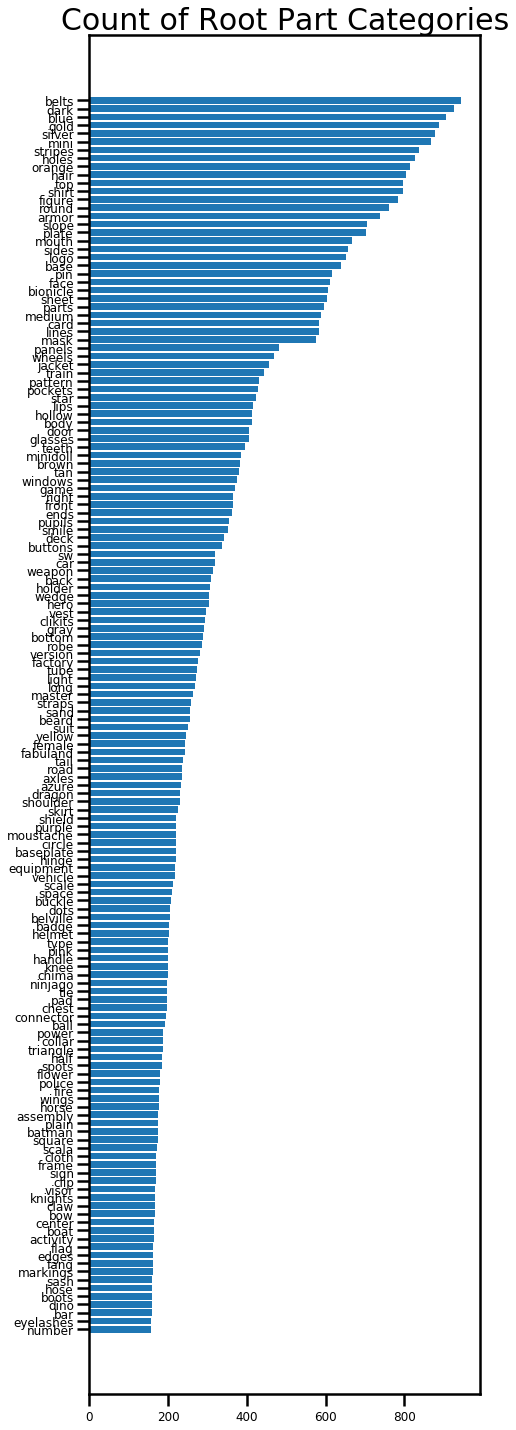

In [45]:
## First generate the labels and axii for the graph.

y_axis = [i[1] for i in max_partscats[:150]]
x_axis = [k for k,i in enumerate(max_partscats[:150])]
x_label = [i[0] for i in max_partscats]

## Start the plot

sns.set_context("poster", rc = {"font.size" : 10, "axes.titlesize" : 30})   
fig, ax = plt.subplots(figsize = (7, 25))
_ = plt.xticks(fontsize = 12)
_ = plt.yticks(fontsize = 12)
_ = plt.yticks(x_axis, x_label)
_ = ax.barh(x_axis, y_axis, align = 'center')
_ = ax.invert_yaxis()
_ = plt.title("Count of Root Part Categories")
plt.show()

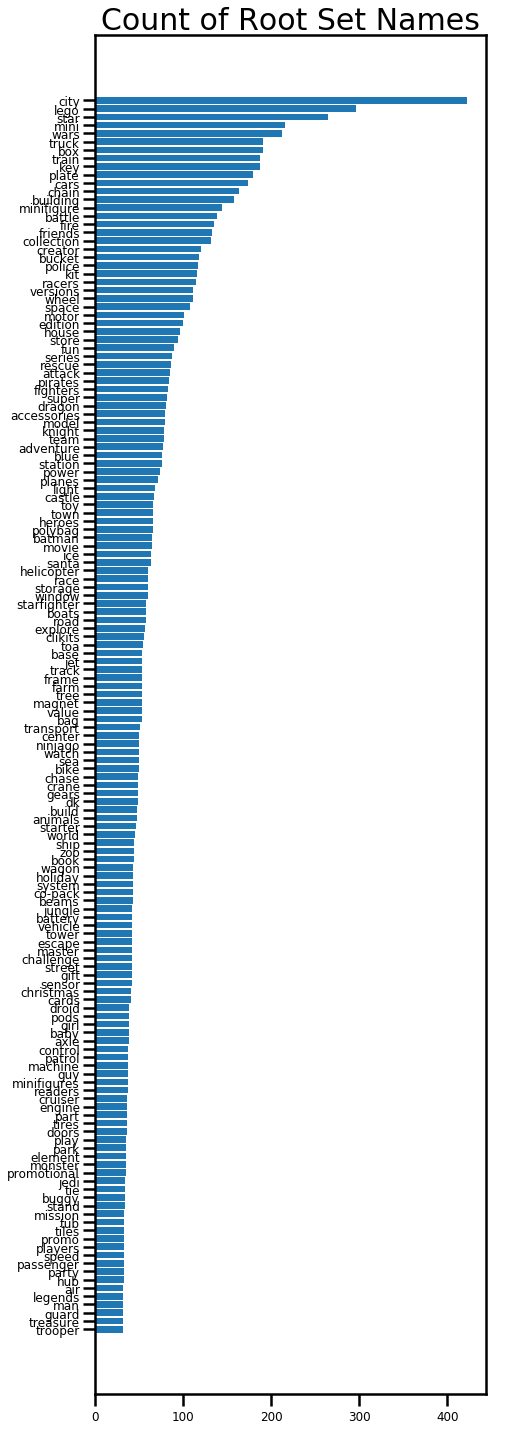

In [46]:
## First generate the labels and axii for the graph.

y_axis = [i[1] for i in max_sets[:150]]
x_axis = [k for k,i in enumerate(max_sets[:150])]
x_label = [i[0] for i in max_sets]

## Start the plot

sns.set_context("poster", rc = {"font.size" : 10, "axes.titlesize" : 30})   
fig, ax = plt.subplots(figsize = (7, 25))
_ = plt.xticks(fontsize = 12)
_ = plt.yticks(fontsize = 12)
_ = plt.yticks(x_axis, x_label)
_ = ax.barh(x_axis, y_axis, align = 'center')
_ = ax.invert_yaxis()
_ = plt.title("Count of Root Set Names")
plt.show()

In [47]:
## Prune the number of selected keywords from visualization that provide little analytical value. 
## Some are incorrect keywords (len(k) <= 2) and some keywords have small counts  (v < 20).

category_occurrence_sets = []

for k,v in setcount_keywords.items():
    
    if (len(k)) <= 1 or (v <= 2): 
        continue
        
    else:
        category_occurrence_sets.append([k,v])

In [48]:
category_occurrence_partcat = []

for k,v in partcatcount_keywords.items():
    if (len(k)) <= 2 or (v <= 20): 
        continue
    elif k in ['blue', 'gold','silver', 'orange', 'pink', 'yellow', '//']: 
        continue
    else:
        category_occurrence_partcat.append([k,v])



In [49]:
## Cluster analysis requires you to have Euclidean distances. Here I am creating an 2D space using the occurrences of the
## set name column creating a dataframe w/ Products on both the index and columns with a 1 for an occurrence, 0 otherwise.


X_sets = pd.DataFrame()
for k,v in category_occurrence_sets:
    word_as_formatted = k.capitalize()
    X_sets.loc[:,k] = np.where(sets_unique.names.str.contains(word_as_formatted),1, 0)
X_sets.set_index(sets_unique.names, inplace = True)

In [50]:
X_partcat = pd.DataFrame()
for k,v in category_occurrence_partcat:
    word_as_formatted = k.capitalize()
    X_partcat.loc[:,k] = np.where(partcat_unique.description.str.contains(word_as_formatted),1, 0)
X_partcat.set_index(partcat_unique.description, inplace = True)

In [51]:
## These groups based on membership count. Only for set name 
## Iterate through the dataframe based on the groups and update it to 1 if condition met.

sets_groups   = sandbox.groupby('set_name').count()['child_themename']

quantile_threshold = [9,52]
X_sets['low']           = np.where(sets_groups <= quantile_threshold[0],1, 0)
X_sets['medium']        = np.where(np.logical_and(sets_groups > quantile_threshold[0], sets_groups < quantile_threshold[1]), 1, 0 )
X_sets['high']          = np.where(sets_groups >= quantile_threshold[1], 1, 0) 

In [52]:
## Kmeans is unsupervised. Looking for optimal cluster amount.

feature_matrix_sets = X_sets.as_matrix()
for cluster_selection in range(3,7):
    kmeans_sets = KMeans(init ='k-means++', n_clusters = cluster_selection, n_init = 100, max_iter = 700)
    kmeans_sets.fit(feature_matrix_sets)
    clusters_sets = kmeans_sets.predict(feature_matrix_sets)
    mean_score_sets = silhouette_score(feature_matrix_sets, clusters_sets)
    print(f"For cluster {cluster_selection}, The average silhouette_score is : {mean_score_sets}")

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=700,
    n_clusters=3, n_init=100, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

For cluster 3, The average silhouette_score is : 0.13990126351715465


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=700,
    n_clusters=4, n_init=100, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

For cluster 4, The average silhouette_score is : 0.14396070132483688


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=700,
    n_clusters=5, n_init=100, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

For cluster 5, The average silhouette_score is : 0.11822641927119014


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=700,
    n_clusters=6, n_init=100, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

For cluster 6, The average silhouette_score is : 0.11305486517548535


In [54]:
feature_matrix_partcat = X_partcat.as_matrix()
for cluster_selection in range(3,7):
    kmeans_partcat = KMeans(init ='k-means++', n_clusters = cluster_selection, n_init = 100, max_iter = 700)
    kmeans_partcat.fit(feature_matrix_partcat)
    clusters_partcat = kmeans_partcat.predict(feature_matrix_partcat)
    mean_score_partcat = silhouette_score(feature_matrix_partcat, clusters_partcat)
    print(f"For cluster {cluster_selection}, The average silhouette_score is : {mean_score_partcat}")

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=700,
    n_clusters=3, n_init=100, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

For cluster 3, The average silhouette_score is : 0.16696011114148387


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=700,
    n_clusters=4, n_init=100, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

For cluster 4, The average silhouette_score is : 0.08043706358497824


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=700,
    n_clusters=5, n_init=100, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

For cluster 5, The average silhouette_score is : 0.08785251733860143


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=700,
    n_clusters=6, n_init=100, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

For cluster 6, The average silhouette_score is : 0.08561621660595765


In [55]:
## Optimal amount found in above cell. Doing it again forreal. 
## Silhouette score judges how tightly clustered the groups are within themselves and afar from others. 
feature_matrix_sets = X_sets.as_matrix()
kmeans_sets = KMeans(init = 'k-means++', n_clusters = 4, n_init = 100, max_iter = 700)
kmeans_sets.fit(feature_matrix_sets)
clusters_sets = kmeans_sets.predict(feature_matrix_sets)
mean_score_sets = silhouette_score(feature_matrix_sets, clusters_sets)
indici_location_sets = kmeans_sets.labels_
centroid_values_sets = kmeans_sets.cluster_centers_
print(f"The average silhouette_score is : {mean_score_sets}")

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=700,
    n_clusters=4, n_init=100, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

The average silhouette_score is : 0.14396070132483688


In [56]:
feature_matrix_partcat = X_partcat.as_matrix()
kmeans_partcat = KMeans(init = 'k-means++', n_clusters = 3, n_init = 100, max_iter = 700)
kmeans_partcat.fit(feature_matrix_partcat)
clusters_partcat = kmeans_partcat.predict(feature_matrix_partcat)
mean_score_partcat = silhouette_score(feature_matrix_partcat, clusters_partcat)
indici_location_partcat = kmeans_partcat.labels_
centroid_values_partcat = kmeans_partcat.cluster_centers_
print(f"The average silhouette_score is : {mean_score_partcat}")

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=700,
    n_clusters=3, n_init=100, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

The average silhouette_score is : 0.16696011114148387


In [57]:
## Graph out the silhouette score.  Refactored from sklearn documentation
    
def silhouette_graph(cluster_size, x_bound, features_len, silhouette_values, cluster_algorithim):
    
    '''
    Purpose : This graph plots out the silhouette score for every cluster created. Silhouette scores are from -1 to 1. 
    
    Requirements: 
    
    1. A cluster (Kmeans, GMM, etc) has to already be created and optimized
    2. Feature matrix needs to be initialized
    3. Run silhouette samples on all of the feature matrix based on the indices 
    
    '''
    
    
    sns.set_context("poster", rc = {"font.size" : 10, "axes.titlesize" : 30})   
    plt.rcParams["patch.force_edgecolor"] = True
    plt.rc('patch', edgecolor = 'dimgray', linewidth=1)
    
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([x_bound[0], x_bound[1]])
    ax1.set_ylim([0, features_len + (cluster_size + 1) * 10])
    y_bound = 10
    
    for i in range(cluster_size):
        
        ## Calculating silhouette scores for all clusters 
        cluster_values = silhouette_values[cluster_algorithim == i]
        cluster_values.sort()
        cluster_shape = cluster_values.shape[0]
        y_limit = y_bound + cluster_shape
        color = plt.cm.Spectral(float(i) / cluster_size)        
        ax1.fill_betweenx(np.arange(y_bound, y_limit), 0, cluster_values,
                           facecolor = color, edgecolor = color, alpha = 0.8)

        ## Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.03, y_bound + 0.5 * cluster_shape, str(i), color = 'red', fontweight = 'bold',
                bbox = dict(facecolor ='white', edgecolor ='black', boxstyle = 'round,pad=0.3'))
   
        ## New y bound for next plot
        y_lower = y_limit + 10  

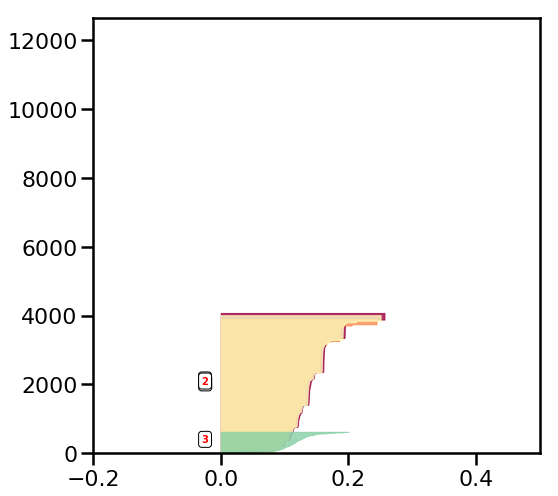

In [59]:
silhouette_numeric_sets = silhouette_samples(feature_matrix_sets, clusters_sets)
silhouette_graph(4, [-.2, 0.5], len(X_sets), silhouette_numeric_sets, clusters_sets)

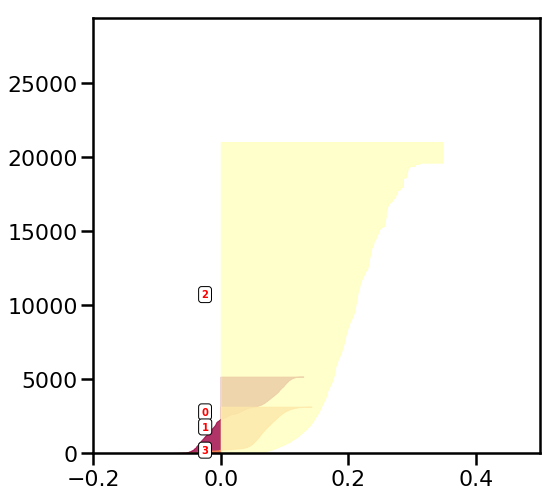

In [61]:
silhouette_numeric_partcat = silhouette_samples(feature_matrix_partcat, clusters_partcat)
silhouette_graph(4, [-.2, 0.5], len(X_partcat), silhouette_numeric_partcat, clusters_partcat)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

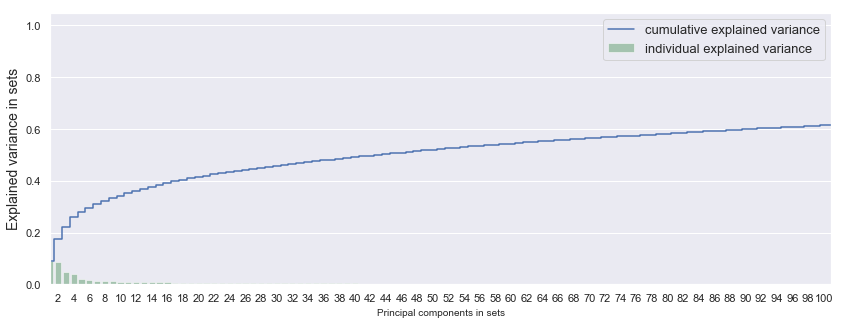

In [65]:
## PCA to see if the clusters explain the variance of the partdescription_name column

principals_sets = PCA()
principals_sets.fit(feature_matrix_sets)
pca_exposed_sets = principals_sets.transform(feature_matrix_sets)

fig, ax = plt.subplots(figsize = (14, 5))
sns.set(font_scale = 1)
_ = plt.step(range(feature_matrix_sets.shape[1]), principals_sets.explained_variance_ratio_.cumsum(), where = 'mid',
         label = 'cumulative explained variance')
_ = sns.barplot(np.arange(1,feature_matrix_sets.shape[1] + 1), principals_sets.explained_variance_ratio_, 
                alpha = 0.5, color = 'g',label = 'individual explained variance')
_ = plt.xlim(0, 100)

_ = ax.set_xticklabels([tick if int(tick.get_text()) % 2 == 0 else "" for tick in ax.get_xticklabels()])

_ = plt.ylabel('Explained variance in sets', fontsize = 14)
_ = plt.xlabel('Principal components in sets', fontsize = 10)
_ = plt.legend(loc = 'best', fontsize = 13)

plt.show()

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

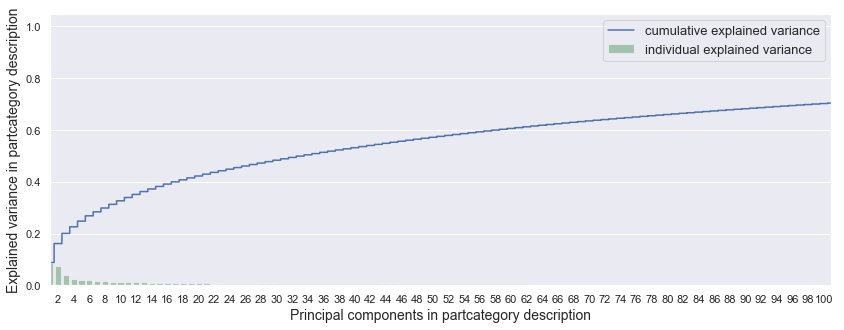

In [64]:
principals_partcat = PCA()
principals_partcat.fit(feature_matrix_partcat)
pca_exposed_partcat = principals_partcat.transform(feature_matrix_partcat)

fig, ax = plt.subplots(figsize = (14, 5))
sns.set(font_scale = 1)
_ = plt.step(range(feature_matrix_partcat.shape[1]), principals_partcat.explained_variance_ratio_.cumsum(), where = 'mid',
         label = 'cumulative explained variance')
_ = sns.barplot(np.arange(1,feature_matrix_partcat.shape[1] + 1), principals_partcat.explained_variance_ratio_, 
                alpha = 0.5, color = 'g',label = 'individual explained variance')
_ = plt.xlim(0, 100)

_ = ax.set_xticklabels([tick if int(tick.get_text()) % 2 == 0 else "" for tick in ax.get_xticklabels()])

_ = plt.ylabel('Explained variance in partcategory description', fontsize = 14)
_ = plt.xlabel('Principal components in partcategory description', fontsize = 14)
_ = plt.legend(loc ='best', fontsize = 13)

plt.show()

## Analyst Notes
- In this section, I try to get a better understanding of the dataset by performing KMeans on two different columns: partcategory description and set name.
- Although the Principal component analysis shows that the components found within the columns explain an upadwards of 70% of the variance there is no global disjointedness for the dataset to be grouped and shown in a radar analysis. 
- The silhouette score backs up this claim. The score is positive on a scale of -1 to 1 which means the clusters are well formed, but the data inherently has a lot of overlap
- This leads to belief that number of parts over the years has grown not due to a vast difference in the type of parts or sets being introduced, but rather the themes themselves must have evolved over time along with big sets using a lot of similiar parts.

## Part 3

## Feature Engineering

In [68]:
## Split out Dataframe.
## Tsfresh for easy feature extraction based on time.


summed_parts = sandbox.groupby('year').sum()['quantity_part']

theme_counts = sandbox.groupby('year').count()['child_themename']

themes = pd.DataFrame(theme_counts)

X = pd.DataFrame(summed_parts)

In [69]:
X = X.iloc[:-1]
regression_themes = themes.iloc[1:-1]

In [70]:
df_shift, y = make_forecasting_frame(X.quantity_part, max_timeshift = 6, 
                                     rolling_direction = 2 , kind = "demand")

Forecast_Feature = extract_features(df_shift, column_id = "id", column_sort = "time", 
                                    column_value = "value", impute_function = impute, 
                                    show_warnings = False)

X_regression = Forecast_Feature.loc[:, Forecast_Feature.apply(pd.Series.nunique) != 1]
X_frame = pd.concat([X_regression, regression_themes], axis = 1)

print("Number of extracted features: {}. ".format(X.shape[1]))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tsfresh/utilities/dataframe_functions.py:435: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn("Your time stamps are not uniformly sampled, which makes rolling "
Feature Extraction: 100%|██████████| 17/17 [00:01<00:00,  8.02it/s]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"r

Number of extracted features: 1. 


In [71]:
filtered_x = select_features(X_frame, y, ml_task="regression")

train_indices = int(len(filtered_x) * .75)

In [72]:
x_train, x_test = filtered_x.iloc[:train_indices],filtered_x.iloc[train_indices:]

y_train, y_test = y.iloc[:train_indices], y.iloc[train_indices:]

## Learning Error and Regularization Parameters

In [73]:
def rmse(actual, predictions):
    
    len_lst = len(actual)
    error = []
    
    for i in range(0, len_lst):
        error.append((actual[i] - predictions[i]) ** 2)
        
    return (np.array(error).mean()) ** (0.5)

In [74]:
def manual_gradient_descent_optimization(algorithim_scores):
    
    min_val = algorithim_scores[0]
    min_index = 0
    counter = 0
    for score in algorithim_score:
        if (score < min_val):
            
            min_index = counter
            min_val = score
            counter += 1
            
    return (min_index, min_val)

## Models

### Naive SVR

In [75]:
Steps_SVR = [ ("scaler", StandardScaler()),
                                ("SupportVector", LinearSVR(C = 0.25, max_iter = 3000000, dual = False, intercept_scaling = 2.5, loss = 'squared_epsilon_insensitive')),
]

Pipeline_SVR = Pipeline(Steps_SVR)

In [76]:
isp = 1  # index of where to start the predictions

for i in tqdm(range(isp, len(y_train))):
    Pipeline_SVR.fit(x_train, y_train.values.ravel())

  0%|          | 0/49 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('SupportVector', LinearSVR(C=0.25, dual=False, epsilon=0.0, fit_intercept=True,
     intercept_scaling=2.5, loss='squared_epsilon_insensitive',
     max_iter=3000000, random_state=None, tol=0.0001, verbose=0))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('SupportVector', LinearSVR(C=0.25, dual=False, epsilon=0.0, fit_intercept=True,
     intercept_scaling=2.5, loss='squared_epsilon_insensitive',
     max_iter=3000000, random_state=None, tol=0.0001, verbose=0))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('SupportVector', LinearSVR(C=0.25, dual=False, epsilon=0.0, fit_intercept=True,
     intercept_scaling=2.5, loss='squared_epsilon_insensitive',
     max_iter=3000000, random_state=None, tol=0.0001, verbose=0))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('SupportVector', LinearSVR(C=0.25, dual=False, epsilon=0.0, fit_intercept=True,
     intercept_scaling=2.5, loss='squared_epsilon_insensitive',
     max_iter=3000000, random_state=None, tol=0.0001, verbose=0))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('SupportVector', LinearSVR(C=0.25, dual=False, epsilon=0.0, fit_intercept=True,
     intercept_scaling=2.5, loss='squared_epsilon_insensitive',
     max_iter=3000000, random_state=None, tol=0.0001, verbose=0))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('SupportVector', LinearSVR(C=0.25, dual=False, epsilon=0.0, fit_intercept=True,
     intercept_scaling=2.5, loss='squared_epsilon_insensitive',
     max_iter=3000000, random_state=None, tol=0.0001, verbose=0))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('SupportVector', LinearSVR(C=0.25, dual=False, epsilon=0.0, fit_intercept=True,
     intercept_scaling=2.5, loss='squared_epsilon_insensitive',
     max_iter=3000000, random_state=None, tol=0.0001, verbose=0))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('SupportVector', LinearSVR(C=0.25, dual=False, epsilon=0.0, fit_intercept=True,
     intercept_scaling=2.5, loss='squared_epsilon_insensitive',
     max_iter=3000000, random_state=None, tol=0.0001, verbose=0))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('SupportVector', LinearSVR(C=0.25, dual=False, epsilon=0.0, fit_intercept=True,
     intercept_scaling=2.5, loss='squared_epsilon_insensitive',
     max_iter=3000000, random_state=None, tol=0.0001, verbose=0))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('SupportVector', LinearSVR(C=0.25, dual=False, epsilon=0.0, fit_intercept=True,
     intercept_scaling=2.5, loss='squared_epsilon_insensitive',
     max_iter=3000000, random_state=None, tol=0.0001, verbose=0))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('SupportVector', LinearSVR(C=0.25, dual=False, epsilon=0.0, fit_intercept=True,
     intercept_scaling=2.5, loss='squared_epsilon_insensitive',
     max_iter=3000000, random_state=None, tol=0.0001, verbose=0))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('SupportVector', LinearSVR(C=0.25, dual=False, epsilon=0.0, fit_intercept=True,
     intercept_scaling=2.5, loss='squared_epsilon_insensitive',
     max_iter=3000000, random_state=None, tol=0.0001, verbose=0))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('SupportVector', LinearSVR(C=0.25, dual=False, epsilon=0.0, fit_intercept=True,
     intercept_scaling=2.5, loss='squared_epsilon_insensitive',
     max_iter=3000000, random_state=None, tol=0.0001, verbose=0))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('SupportVector', LinearSVR(C=0.25, dual=False, epsilon=0.0, fit_intercept=True,
     intercept_scaling=2.5, loss='squared_epsilon_insensitive',
     max_iter=3000000, random_state=None, tol=0.0001, verbose=0))])

 29%|██▊       | 14/49 [00:00<00:00, 139.54it/s]/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('SupportVector', LinearSVR(C=0.25, dual=False, epsilon=0.0, fit_intercept=True,
     intercept_scaling=2.5, loss='squared_epsilon_insensitive',
     max_iter=3000000, random_state=None, tol=0.0001, verbose=0))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('SupportVector', LinearSVR(C=0.25, dual=False, epsilon=0.0, fit_intercept=True,
     intercept_scaling=2.5, loss='squared_epsilon_insensitive',
     max_iter=3000000, random_state=None, tol=0.0001, verbose=0))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('SupportVector', LinearSVR(C=0.25, dual=False, epsilon=0.0, fit_intercept=True,
     intercept_scaling=2.5, loss='squared_epsilon_insensitive',
     max_iter=3000000, random_state=None, tol=0.0001, verbose=0))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('SupportVector', LinearSVR(C=0.25, dual=False, epsilon=0.0, fit_intercept=True,
     intercept_scaling=2.5, loss='squared_epsilon_insensitive',
     max_iter=3000000, random_state=None, tol=0.0001, verbose=0))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('SupportVector', LinearSVR(C=0.25, dual=False, epsilon=0.0, fit_intercept=True,
     intercept_scaling=2.5, loss='squared_epsilon_insensitive',
     max_iter=3000000, random_state=None, tol=0.0001, verbose=0))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('SupportVector', LinearSVR(C=0.25, dual=False, epsilon=0.0, fit_intercept=True,
     intercept_scaling=2.5, loss='squared_epsilon_insensitive',
     max_iter=3000000, random_state=None, tol=0.0001, verbose=0))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('SupportVector', LinearSVR(C=0.25, dual=False, epsilon=0.0, fit_intercept=True,
     intercept_scaling=2.5, loss='squared_epsilon_insensitive',
     max_iter=3000000, random_state=None, tol=0.0001, verbose=0))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('SupportVector', LinearSVR(C=0.25, dual=False, epsilon=0.0, fit_intercept=True,
     intercept_scaling=2.5, loss='squared_epsilon_insensitive',
     max_iter=3000000, random_state=None, tol=0.0001, verbose=0))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('SupportVector', LinearSVR(C=0.25, dual=False, epsilon=0.0, fit_intercept=True,
     intercept_scaling=2.5, loss='squared_epsilon_insensitive',
     max_iter=3000000, random_state=None, tol=0.0001, verbose=0))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('SupportVector', LinearSVR(C=0.25, dual=False, epsilon=0.0, fit_intercept=True,
     intercept_scaling=2.5, loss='squared_epsilon_insensitive',
     max_iter=3000000, random_state=None, tol=0.0001, verbose=0))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('SupportVector', LinearSVR(C=0.25, dual=False, epsilon=0.0, fit_intercept=True,
     intercept_scaling=2.5, loss='squared_epsilon_insensitive',
     max_iter=3000000, random_state=None, tol=0.0001, verbose=0))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('SupportVector', LinearSVR(C=0.25, dual=False, epsilon=0.0, fit_intercept=True,
     intercept_scaling=2.5, loss='squared_epsilon_insensitive',
     max_iter=3000000, random_state=None, tol=0.0001, verbose=0))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('SupportVector', LinearSVR(C=0.25, dual=False, epsilon=0.0, fit_intercept=True,
     intercept_scaling=2.5, loss='squared_epsilon_insensitive',
     max_iter=3000000, random_state=None, tol=0.0001, verbose=0))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('SupportVector', LinearSVR(C=0.25, dual=False, epsilon=0.0, fit_intercept=True,
     intercept_scaling=2.5, loss='squared_epsilon_insensitive',
     max_iter=3000000, random_state=None, tol=0.0001, verbose=0))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('SupportVector', LinearSVR(C=0.25, dual=False, epsilon=0.0, fit_intercept=True,
     intercept_scaling=2.5, loss='squared_epsilon_insensitive',
     max_iter=3000000, random_state=None, tol=0.0001, verbose=0))])

 59%|█████▉    | 29/49 [00:00<00:00, 142.36it/s]/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('SupportVector', LinearSVR(C=0.25, dual=False, epsilon=0.0, fit_intercept=True,
     intercept_scaling=2.5, loss='squared_epsilon_insensitive',
     max_iter=3000000, random_state=None, tol=0.0001, verbose=0))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('SupportVector', LinearSVR(C=0.25, dual=False, epsilon=0.0, fit_intercept=True,
     intercept_scaling=2.5, loss='squared_epsilon_insensitive',
     max_iter=3000000, random_state=None, tol=0.0001, verbose=0))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('SupportVector', LinearSVR(C=0.25, dual=False, epsilon=0.0, fit_intercept=True,
     intercept_scaling=2.5, loss='squared_epsilon_insensitive',
     max_iter=3000000, random_state=None, tol=0.0001, verbose=0))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('SupportVector', LinearSVR(C=0.25, dual=False, epsilon=0.0, fit_intercept=True,
     intercept_scaling=2.5, loss='squared_epsilon_insensitive',
     max_iter=3000000, random_state=None, tol=0.0001, verbose=0))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('SupportVector', LinearSVR(C=0.25, dual=False, epsilon=0.0, fit_intercept=True,
     intercept_scaling=2.5, loss='squared_epsilon_insensitive',
     max_iter=3000000, random_state=None, tol=0.0001, verbose=0))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('SupportVector', LinearSVR(C=0.25, dual=False, epsilon=0.0, fit_intercept=True,
     intercept_scaling=2.5, loss='squared_epsilon_insensitive',
     max_iter=3000000, random_state=None, tol=0.0001, verbose=0))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('SupportVector', LinearSVR(C=0.25, dual=False, epsilon=0.0, fit_intercept=True,
     intercept_scaling=2.5, loss='squared_epsilon_insensitive',
     max_iter=3000000, random_state=None, tol=0.0001, verbose=0))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('SupportVector', LinearSVR(C=0.25, dual=False, epsilon=0.0, fit_intercept=True,
     intercept_scaling=2.5, loss='squared_epsilon_insensitive',
     max_iter=3000000, random_state=None, tol=0.0001, verbose=0))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('SupportVector', LinearSVR(C=0.25, dual=False, epsilon=0.0, fit_intercept=True,
     intercept_scaling=2.5, loss='squared_epsilon_insensitive',
     max_iter=3000000, random_state=None, tol=0.0001, verbose=0))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('SupportVector', LinearSVR(C=0.25, dual=False, epsilon=0.0, fit_intercept=True,
     intercept_scaling=2.5, loss='squared_epsilon_insensitive',
     max_iter=3000000, random_state=None, tol=0.0001, verbose=0))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('SupportVector', LinearSVR(C=0.25, dual=False, epsilon=0.0, fit_intercept=True,
     intercept_scaling=2.5, loss='squared_epsilon_insensitive',
     max_iter=3000000, random_state=None, tol=0.0001, verbose=0))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('SupportVector', LinearSVR(C=0.25, dual=False, epsilon=0.0, fit_intercept=True,
     intercept_scaling=2.5, loss='squared_epsilon_insensitive',
     max_iter=3000000, random_state=None, tol=0.0001, verbose=0))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('SupportVector', LinearSVR(C=0.25, dual=False, epsilon=0.0, fit_intercept=True,
     intercept_scaling=2.5, loss='squared_epsilon_insensitive',
     max_iter=3000000, random_state=None, tol=0.0001, verbose=0))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('SupportVector', LinearSVR(C=0.25, dual=False, epsilon=0.0, fit_intercept=True,
     intercept_scaling=2.5, loss='squared_epsilon_insensitive',
     max_iter=3000000, random_state=None, tol=0.0001, verbose=0))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('SupportVector', LinearSVR(C=0.25, dual=False, epsilon=0.0, fit_intercept=True,
     intercept_scaling=2.5, loss='squared_epsilon_insensitive',
     max_iter=3000000, random_state=None, tol=0.0001, verbose=0))])

 90%|████████▉ | 44/49 [00:00<00:00, 143.84it/s]/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('SupportVector', LinearSVR(C=0.25, dual=False, epsilon=0.0, fit_intercept=True,
     intercept_scaling=2.5, loss='squared_epsilon_insensitive',
     max_iter=3000000, random_state=None, tol=0.0001, verbose=0))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('SupportVector', LinearSVR(C=0.25, dual=False, epsilon=0.0, fit_intercept=True,
     intercept_scaling=2.5, loss='squared_epsilon_insensitive',
     max_iter=3000000, random_state=None, tol=0.0001, verbose=0))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('SupportVector', LinearSVR(C=0.25, dual=False, epsilon=0.0, fit_intercept=True,
     intercept_scaling=2.5, loss='squared_epsilon_insensitive',
     max_iter=3000000, random_state=None, tol=0.0001, verbose=0))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('SupportVector', LinearSVR(C=0.25, dual=False, epsilon=0.0, fit_intercept=True,
     intercept_scaling=2.5, loss='squared_epsilon_insensitive',
     max_iter=3000000, random_state=None, tol=0.0001, verbose=0))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('SupportVector', LinearSVR(C=0.25, dual=False, epsilon=0.0, fit_intercept=True,
     intercept_scaling=2.5, loss='squared_epsilon_insensitive',
     max_iter=3000000, random_state=None, tol=0.0001, verbose=0))])

100%|██████████| 49/49 [00:00<00:00, 145.45it/s]


In [77]:
Naive_SVR = Pipeline_SVR.predict(x_test)
Naive_SVR = pd.Series(data = Naive_SVR, index = y_test.index)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


### Naive Elastic Net

In [78]:
Steps_ElasticNet = [
                     ("scaler", StandardScaler()),
                                    ("elasticnet", ElasticNet(max_iter = 30000000, l1_ratio = .51, normalize = True, precompute = True, selection = 'random', tol = .001)),
            
                                                                                        ]

Pipeline_ElasticNet = Pipeline(Steps_ElasticNet)

In [79]:
for i in tqdm(range(isp, len(x_train))):
    Pipeline_ElasticNet.fit(x_train, y_train.values.ravel())

  0%|          | 0/49 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elasticnet', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.51,
      max_iter=30000000, normalize=True, positive=False, precompute=True,
      random_state=None, selection='random', tol=0.001, warm_start=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elasticnet', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.51,
      max_iter=30000000, normalize=True, positive=False, precompute=True,
      random_state=None, selection='random', tol=0.001, warm_start=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elasticnet', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.51,
      max_iter=30000000, normalize=True, positive=False, precompute=True,
      random_state=None, selection='random', tol=0.001, warm_start=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elasticnet', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.51,
      max_iter=30000000, normalize=True, positive=False, precompute=True,
      random_state=None, selection='random', tol=0.001, warm_start=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elasticnet', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.51,
      max_iter=30000000, normalize=True, positive=False, precompute=True,
      random_state=None, selection='random', tol=0.001, warm_start=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elasticnet', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.51,
      max_iter=30000000, normalize=True, positive=False, precompute=True,
      random_state=None, selection='random', tol=0.001, warm_start=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elasticnet', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.51,
      max_iter=30000000, normalize=True, positive=False, precompute=True,
      random_state=None, selection='random', tol=0.001, warm_start=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elasticnet', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.51,
      max_iter=30000000, normalize=True, positive=False, precompute=True,
      random_state=None, selection='random', tol=0.001, warm_start=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elasticnet', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.51,
      max_iter=30000000, normalize=True, positive=False, precompute=True,
      random_state=None, selection='random', tol=0.001, warm_start=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elasticnet', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.51,
      max_iter=30000000, normalize=True, positive=False, precompute=True,
      random_state=None, selection='random', tol=0.001, warm_start=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elasticnet', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.51,
      max_iter=30000000, normalize=True, positive=False, precompute=True,
      random_state=None, selection='random', tol=0.001, warm_start=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elasticnet', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.51,
      max_iter=30000000, normalize=True, positive=False, precompute=True,
      random_state=None, selection='random', tol=0.001, warm_start=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elasticnet', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.51,
      max_iter=30000000, normalize=True, positive=False, precompute=True,
      random_state=None, selection='random', tol=0.001, warm_start=False))])

 27%|██▋       | 13/49 [00:00<00:00, 121.72it/s]/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elasticnet', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.51,
      max_iter=30000000, normalize=True, positive=False, precompute=True,
      random_state=None, selection='random', tol=0.001, warm_start=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elasticnet', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.51,
      max_iter=30000000, normalize=True, positive=False, precompute=True,
      random_state=None, selection='random', tol=0.001, warm_start=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elasticnet', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.51,
      max_iter=30000000, normalize=True, positive=False, precompute=True,
      random_state=None, selection='random', tol=0.001, warm_start=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elasticnet', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.51,
      max_iter=30000000, normalize=True, positive=False, precompute=True,
      random_state=None, selection='random', tol=0.001, warm_start=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elasticnet', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.51,
      max_iter=30000000, normalize=True, positive=False, precompute=True,
      random_state=None, selection='random', tol=0.001, warm_start=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elasticnet', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.51,
      max_iter=30000000, normalize=True, positive=False, precompute=True,
      random_state=None, selection='random', tol=0.001, warm_start=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elasticnet', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.51,
      max_iter=30000000, normalize=True, positive=False, precompute=True,
      random_state=None, selection='random', tol=0.001, warm_start=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elasticnet', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.51,
      max_iter=30000000, normalize=True, positive=False, precompute=True,
      random_state=None, selection='random', tol=0.001, warm_start=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elasticnet', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.51,
      max_iter=30000000, normalize=True, positive=False, precompute=True,
      random_state=None, selection='random', tol=0.001, warm_start=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elasticnet', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.51,
      max_iter=30000000, normalize=True, positive=False, precompute=True,
      random_state=None, selection='random', tol=0.001, warm_start=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elasticnet', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.51,
      max_iter=30000000, normalize=True, positive=False, precompute=True,
      random_state=None, selection='random', tol=0.001, warm_start=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elasticnet', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.51,
      max_iter=30000000, normalize=True, positive=False, precompute=True,
      random_state=None, selection='random', tol=0.001, warm_start=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elasticnet', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.51,
      max_iter=30000000, normalize=True, positive=False, precompute=True,
      random_state=None, selection='random', tol=0.001, warm_start=False))])

 53%|█████▎    | 26/49 [00:00<00:00, 123.85it/s]/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elasticnet', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.51,
      max_iter=30000000, normalize=True, positive=False, precompute=True,
      random_state=None, selection='random', tol=0.001, warm_start=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elasticnet', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.51,
      max_iter=30000000, normalize=True, positive=False, precompute=True,
      random_state=None, selection='random', tol=0.001, warm_start=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elasticnet', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.51,
      max_iter=30000000, normalize=True, positive=False, precompute=True,
      random_state=None, selection='random', tol=0.001, warm_start=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elasticnet', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.51,
      max_iter=30000000, normalize=True, positive=False, precompute=True,
      random_state=None, selection='random', tol=0.001, warm_start=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elasticnet', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.51,
      max_iter=30000000, normalize=True, positive=False, precompute=True,
      random_state=None, selection='random', tol=0.001, warm_start=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elasticnet', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.51,
      max_iter=30000000, normalize=True, positive=False, precompute=True,
      random_state=None, selection='random', tol=0.001, warm_start=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elasticnet', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.51,
      max_iter=30000000, normalize=True, positive=False, precompute=True,
      random_state=None, selection='random', tol=0.001, warm_start=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elasticnet', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.51,
      max_iter=30000000, normalize=True, positive=False, precompute=True,
      random_state=None, selection='random', tol=0.001, warm_start=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elasticnet', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.51,
      max_iter=30000000, normalize=True, positive=False, precompute=True,
      random_state=None, selection='random', tol=0.001, warm_start=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elasticnet', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.51,
      max_iter=30000000, normalize=True, positive=False, precompute=True,
      random_state=None, selection='random', tol=0.001, warm_start=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elasticnet', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.51,
      max_iter=30000000, normalize=True, positive=False, precompute=True,
      random_state=None, selection='random', tol=0.001, warm_start=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elasticnet', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.51,
      max_iter=30000000, normalize=True, positive=False, precompute=True,
      random_state=None, selection='random', tol=0.001, warm_start=False))])

 78%|███████▊  | 38/49 [00:00<00:00, 121.71it/s]/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elasticnet', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.51,
      max_iter=30000000, normalize=True, positive=False, precompute=True,
      random_state=None, selection='random', tol=0.001, warm_start=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elasticnet', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.51,
      max_iter=30000000, normalize=True, positive=False, precompute=True,
      random_state=None, selection='random', tol=0.001, warm_start=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elasticnet', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.51,
      max_iter=30000000, normalize=True, positive=False, precompute=True,
      random_state=None, selection='random', tol=0.001, warm_start=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elasticnet', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.51,
      max_iter=30000000, normalize=True, positive=False, precompute=True,
      random_state=None, selection='random', tol=0.001, warm_start=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elasticnet', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.51,
      max_iter=30000000, normalize=True, positive=False, precompute=True,
      random_state=None, selection='random', tol=0.001, warm_start=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elasticnet', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.51,
      max_iter=30000000, normalize=True, positive=False, precompute=True,
      random_state=None, selection='random', tol=0.001, warm_start=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elasticnet', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.51,
      max_iter=30000000, normalize=True, positive=False, precompute=True,
      random_state=None, selection='random', tol=0.001, warm_start=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elasticnet', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.51,
      max_iter=30000000, normalize=True, positive=False, precompute=True,
      random_state=None, selection='random', tol=0.001, warm_start=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elasticnet', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.51,
      max_iter=30000000, normalize=True, positive=False, precompute=True,
      random_state=None, selection='random', tol=0.001, warm_start=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elasticnet', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.51,
      max_iter=30000000, normalize=True, positive=False, precompute=True,
      random_state=None, selection='random', tol=0.001, warm_start=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elasticnet', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.51,
      max_iter=30000000, normalize=True, positive=False, precompute=True,
      random_state=None, selection='random', tol=0.001, warm_start=False))])

100%|██████████| 49/49 [00:00<00:00, 124.31it/s]


In [80]:
Naive_ElasticNet = Pipeline_ElasticNet.predict(x_test)
Naive_ElasticNet = pd.Series(Naive_ElasticNet, index = x_test.index)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


### Linear Reg

In [81]:
Steps_Linear = [#('polynomial_features',PolynomialFeatures(degree=2,
                 #                            include_bias=False, interaction_only = True)),
                  ("scaler", StandardScaler()),
                            ("linearregression", LinearRegression(fit_intercept = True, normalize = False))]

In [82]:
Pipeline_Linear = Pipeline(Steps_Linear)

In [83]:
for i in tqdm(range(isp, len(y_train))):
    Pipeline_Linear.fit(x_train, y_train.values.ravel())

  0%|          | 0/49 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

 31%|███       | 15/49 [00:00<00:00, 141.17it/s]/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

 61%|██████    | 30/49 [00:00<00:00, 141.99it/s]/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

 92%|█████████▏| 45/49 [00:00<00:00, 142.47it/s]/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

100%|██████████| 49/49 [00:00<00:00, 141.88it/s]


In [84]:
Linear_Reg = Pipeline_Linear.predict(x_test)
Linear_Reg = pd.DataFrame(Linear_Reg, columns = ["Qty"], 
                                  index = x_test.index)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [85]:
## Create a weighted predictions of all models based on error. Using two models 
models_combined = pd.concat([Naive_ElasticNet, Naive_SVR, y_test], axis = 1)

models_combined.columns = ["Elastic_Regressor", "SVR_Regressor", 'Actuals']

import operator
mean_values = []

for k,v in models_combined.iterrows():
    elastic_error = (v[0] - v[2]) ** 2
    svr_error = (v[1] - v[2]) ** 2
    error_rates = [elastic_error, svr_error]
    min_index, min_value = min(enumerate(error_rates), key=operator.itemgetter(1))
    max_index, max_value = max(enumerate(error_rates), key=operator.itemgetter(1))
    scores_weighted = (v[min_index] * .75) + (v[max_index] * .25)
    mean_values.append(scores_weighted)
mean_dataframe1 = pd.DataFrame(mean_values, index = y_test.index)   

In [87]:
## Create a weighted predictions of all models based on error. Using three models


models_combined = pd.concat([Linear_Reg,Naive_ElasticNet, Naive_SVR, y_test], axis = 1)

models_combined.columns = ["Linear_Reggessor", "Elastic_Regressor", "SVR_Regressor", 'Actuals']

import operator
mean_values = []

for k,v in models_combined.iterrows():
    lr_error = (v[0] - v[3]) ** 2
    elastic_error = (v[1] - v[3]) ** 2
    svr_error = (v[2] - v[3]) ** 2
    error_rates = [lr_error, elastic_error, svr_error]
    list_len = 3
    min_index, min_value = min(enumerate(error_rates), key=operator.itemgetter(1))
    max_index, max_value = max(enumerate(error_rates), key=operator.itemgetter(1))
    final_position = list_len - (min_index + max_index)
    scores_weighted = ((v[min_index] * .80) + (v[max_index] * .05) + (v[final_position] * .15))
    mean_values.append(scores_weighted)
mean_dataframe2 = pd.DataFrame(mean_values, index = y_test.index)   

## Models Visualization and Validation

<Figure size 432x288 with 0 Axes>

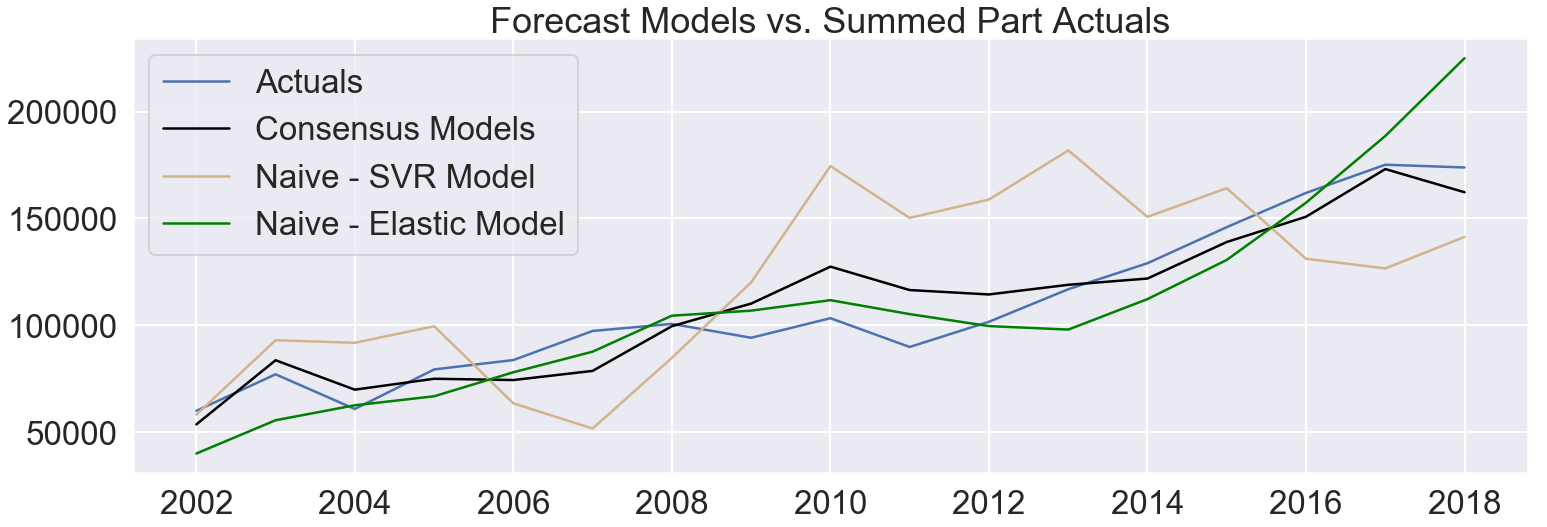

In [88]:
sns.set_style("darkgrid")
sns.set_context("poster", font_scale = 1.5, rc = {"lines.linewidth": 2.5})
sns.despine()

_ = plt.figure(figsize=(25, 8))
_ = plt.plot(y_test, label = "Actuals")
_ = plt.plot(mean_dataframe1, color = "black", label = "Consensus Models")
_ = plt.plot(Naive_SVR, color = "tan", label = "Naive - SVR Model")
_ = plt.plot(Naive_ElasticNet, color = "green", label = "Naive - Elastic Model")
#_ = plt.plot(Linear_Reg, color = "red", label = "Linear Regression - Model")
_ = plt.title("Forecast Models vs. Summed Part Actuals")
_ = plt.legend()

plt.show()



<Figure size 432x288 with 0 Axes>

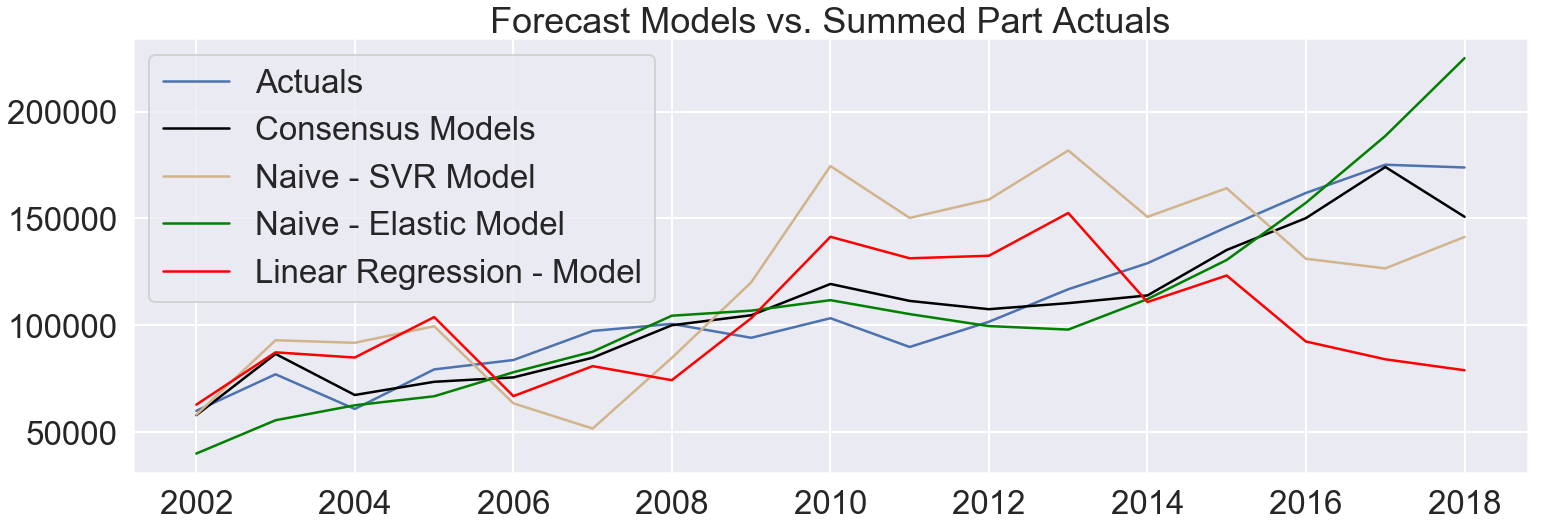

In [89]:
sns.set_style("darkgrid")
sns.set_context("poster", font_scale = 1.5, rc = {"lines.linewidth": 2.5})
sns.despine()

_ = plt.figure(figsize=(25, 8))
_ = plt.plot(y_test, label = "Actuals")
_ = plt.plot(mean_dataframe2, color = "black", label = "Consensus Models")
_ = plt.plot(Naive_SVR, color = "tan", label = "Naive - SVR Model")
_ = plt.plot(Naive_ElasticNet, color = "green", label = "Naive - Elastic Model")
_ = plt.plot(Linear_Reg, color = "red", label = "Linear Regression - Model")
_ = plt.title("Forecast Models vs. Summed Part Actuals")
_ = plt.legend()

plt.show()


